# Discrete Fourier Transform (DFT)

The Discrete Fourier Transform (DFT) is a fundamental technique for digital signal/image processing commonly applied for frequency domain representation of a finite sequence of a regularly sampled function. The DFT is efficiently implemented using the Fast Fourier Transform algorithm and provides an excellent frequency representation of the input signal. However, the Fourier Transform is limited in its application due to its lack of event localization. This problem is overcome by the short-time variant of the FFT algorithm, the Short Time Fourier Transform (STFT), which performs the Fourier Transform on windowed segments of the input signal. In this way, the method provides temporal/spatial localization, albeit at the expense of time or frequency resolution (time-frequency resolution trade-off). Small window sizes will yield a high temporal resolution but low-frequency resolution. Conversely, a long window size results in a higher frequency resolution but lower temporal resolution. The Discrete Wavelet Transform (DWT), an analog to the DFT, utilizes wavelet functions for multi-resolution frequency decomposition and event localization.

### Citation:
The Stratton seismic data used in this notebook was collected and made available for worldwide education and training by the Bureau of Economic Geology at the University of Texas at Austin. It can be downloaded from the SEG Wiki Open Data directory https://wiki.seg.org/wiki/Stratton_3D_survey

In [1]:
# pip install pathlib
# pip install segysak

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pathlib
import segysak
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
ST3D_path = pathlib.Path('Stratton3D_32bit.sgy')
ST3D_path

WindowsPath('Stratton3D_32bit.sgy')

In [4]:
from segysak.segy import get_segy_texthead

In [5]:
get_segy_texthead(ST3D_path)

Text HeaderC01 STRATTON 3D Data Set
C02
C03 32-bit 3-D Volume
C04
C05
C06 DATA FORMAT      : IBM FLOATING POINT
C07
C08 HEADER PARAMETER VALUE LOCATIONS:
C09 PARAMETER NAME       HEADER CONTAINING VALUE    BYTE RANGE
C10 ==========================================================
C11   LINE NUMBER          BINARY                       5 - 8
C12   DATA FORMAT CODE     BINARY                      25 - 26
C13
C14   LINE NUMBER          TRACE                        9 - 12
C15   CDP NUMBER           TRACE                       21 - 24
C16   X LOCATION           TRACE                       73 - 76
C17   Y LOCATION           TRACE                       77 - 80
C18   X LOCATION           TRACE                       81 - 84
C19   Y LOCATION           TRACE                       85 - 88
C20   START TIME           TRACE                      109 - 110
C21   NUMBER OF SAMPLES    TRACE                      115 - 116
C22   SAMPLE RATE (USEC)   TRACE                      117 - 118
C23
C24
C25
C26
C27
C28
C29
C30
C31
C32
C33
C34
C35
C36
C37
C38
C39 written from EGLTools for Matlab on 16-Mar-2007
C40  EGL Archive Copy

In [6]:
from segysak.segy import segy_header_scan

In [7]:
scan = segy_header_scan(ST3D_path)
scan[scan['std']>0]

byte_loc   count       mean          std        min  \
TRACE_SEQUENCE_LINE         1  1000.0      109.5    67.206895        1.0   
FieldRecord                 9  1000.0        3.7     1.269493        2.0   
CDP                        21  1000.0      109.5    67.206895        1.0   
SourceX                    73  1000.0  2187777.5  3696.379238  2181150.0   
SourceY                    77  1000.0   705643.5    69.822096   705550.0   
GroupX                     81  1000.0  2187777.5  3696.379238  2181150.0   
GroupY                     85  1000.0   705643.5    69.822096   705550.0   

                            25%        50%         75%        max  
TRACE_SEQUENCE_LINE       50.75      105.5      168.00      230.0  
FieldRecord                3.00        4.0        5.00        6.0  
CDP                       50.75      105.5      168.00      230.0  
SourceX              2184560.00  2187997.5  2191008.75  2193745.0  
SourceY               705605.00   705660.0   705715.00   705770.0  
GroupX               2184560.00  2187997.5  2191008.75  2193745.0  
GroupY                705605.00   705660.0   705715.00   705770.0

In [8]:
from segysak.segy import segy_loader, well_known_byte_locs

In [9]:
ST3D_volume = segy_loader(ST3D_path, iline=9, xline=21, cdpx=81, cdpy=85, vert_domain='TWT')
ST3D_volume


Loading as 3D
Fast direction is CDP


<xarray.Dataset>
Dimensions:  (iline: 309, twt: 1501, xline: 230)
Coordinates:
  * iline    (iline) int32 2 3 4 5 6 7 8 9 ... 303 304 305 306 307 308 309 310
  * xline    (xline) int32 1 2 3 4 5 6 7 8 9 ... 223 224 225 226 227 228 229 230
  * twt      (twt) float64 0.0 2.0 4.0 6.0 ... 2.996e+03 2.998e+03 3e+03
    cdp_x    (iline, xline) float64 2.194e+06 2.194e+06 ... 2.181e+06 2.181e+06
    cdp_y    (iline, xline) float64 7.056e+05 7.056e+05 ... 7.225e+05 7.225e+05
Data variables:
    data     (iline, xline, twt) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    ns:                  None
    sample_rate:         2.0
    text:                C01 STRATTON 3D Data Set\nC02\nC03 32-bit 3-D Volume...
    measurement_system:  ft
    d3_domain:           None
    epsg:                None
    corner_points:       None
    corner_points_xy:    None
    source_file:         Stratton3D_32bit.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-0.14259597518499442, -0.12317047291315068, -0.0344...
    coord_scalar:        None

In [10]:
binsize_x = np.diff(ST3D_volume.cdp_x, axis=1)[0]
binsize_y = np.diff(ST3D_volume.cdp_y, axis=0)[0]
timestep_z = np.diff(ST3D_volume.twt)[0]
print('Binsize X: {}'.format(binsize_x[0]), '\n' 'Binsize Y: {}'.format(binsize_y[0]), '\n' 
      'Sample Interval: {}'.format(timestep_z))

Binsize X: -55.0 
Binsize Y: 55.0 
Sample Interval: 2.0


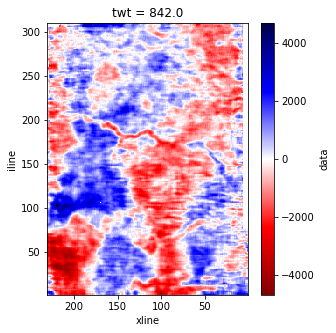

In [11]:
fig, ax = plt.subplots(figsize=(4.5,5))
ST3D_volume.data.sel(twt=842).plot.imshow(ax=ax, cmap='seismic_r')
ax.invert_xaxis()

In [12]:
ST3D_volume_df = ST3D_volume.to_dataframe()
ST3D_volume_df

data      cdp_x     cdp_y
iline twt    xline                           
2     0.0    1       0.0  2193745.0  705550.0
             2       0.0  2193690.0  705550.0
             3       0.0  2193635.0  705550.0
             4       0.0  2193580.0  705550.0
             5       0.0  2193525.0  705550.0
...                  ...        ...       ...
310   3000.0 226     0.0  2181370.0  722490.0
             227     0.0  2181315.0  722490.0
             228     0.0  2181260.0  722490.0
             229     0.0  2181205.0  722490.0
             230     0.0  2181150.0  722490.0

[106676070 rows x 3 columns]

In [13]:
ST3D_volume_df_rsidx = ST3D_volume_df.reset_index()
ST3D_volume_df_rsidx

iline     twt  xline  data      cdp_x     cdp_y
0              2     0.0      1   0.0  2193745.0  705550.0
1              2     0.0      2   0.0  2193690.0  705550.0
2              2     0.0      3   0.0  2193635.0  705550.0
3              2     0.0      4   0.0  2193580.0  705550.0
4              2     0.0      5   0.0  2193525.0  705550.0
...          ...     ...    ...   ...        ...       ...
106676065    310  3000.0    226   0.0  2181370.0  722490.0
106676066    310  3000.0    227   0.0  2181315.0  722490.0
106676067    310  3000.0    228   0.0  2181260.0  722490.0
106676068    310  3000.0    229   0.0  2181205.0  722490.0
106676069    310  3000.0    230   0.0  2181150.0  722490.0

[106676070 rows x 6 columns]

### Extract 1D Signal

Trace - Iline 2 / Xline 1

In [14]:
signal = ST3D_volume_df_rsidx[ST3D_volume_df_rsidx.iline==2]
signal = signal[signal.xline==1]
signal = signal.data.values
signal.shape

(1501,)

In [15]:
time = ST3D_volume_df_rsidx[ST3D_volume_df_rsidx.iline==2]
time = time[time.xline==1]
time = time.twt.values
time.shape

(1501,)

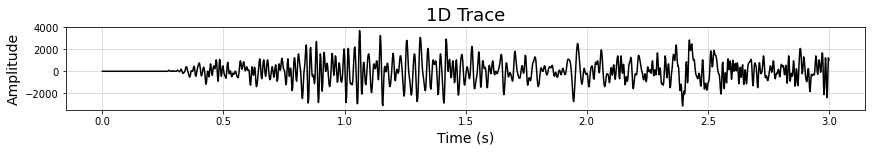

In [16]:
fig, ax = plt.subplots(figsize=(12,2), constrained_layout=True)
ax.plot(time/1e3, signal, color='k')
ax.set_xlabel('Time (s)', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.set_title('1D Trace', size=18)
ax.grid(alpha=0.5)

### Extract 2D Signal

Section - Xline 110

In [17]:
signal_2D = ST3D_volume_df_rsidx[ST3D_volume_df_rsidx.xline==110]
signal_2D = signal_2D.data.values
signal_2D = signal_2D.reshape(309, 1501)
signal_2D.shape

(309, 1501)

In [18]:
iline_2D = ST3D_volume_df_rsidx[ST3D_volume_df_rsidx.xline==110]
iline_2D = iline_2D.iline.values
iline_2D = iline_2D.reshape(309, 1501)
iline_2D.shape

(309, 1501)

In [19]:
twt_2D = ST3D_volume_df_rsidx[ST3D_volume_df_rsidx.xline==110]
twt_2D = twt_2D.twt.values
twt_2D = twt_2D.reshape(309, 1501)
twt_2D.shape

(309, 1501)

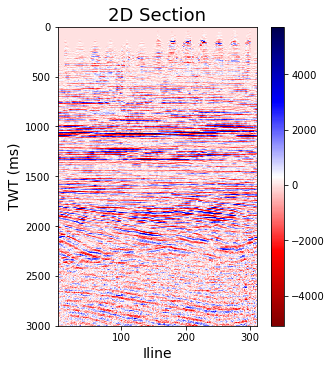

In [20]:
fig, ax = plt.subplots(figsize=(4.5,5), constrained_layout=True)
im = ax.pcolormesh(iline_2D, twt_2D, signal_2D, shading='auto', cmap='seismic_r')
ax.set_xlim([np.amin(iline_2D), np.amax(iline_2D)])
ax.set_ylim([np.amin(twt_2D), np.amax(twt_2D)])
ax.set_xlabel('Iline', size=14)
ax.set_ylabel('TWT (ms)', size=14)
ax.set_title('2D Section', size=18)
ax.invert_yaxis()
fig.colorbar(im, ax=ax)

### Extract 3D Signal

Full Volume

In [21]:
signal_3D = ST3D_volume_df_rsidx
signal_3D = signal_3D.data.values
signal_3D = signal_3D.reshape(309, 1501, 230)
signal_3D = signal_3D.transpose(0, 2, 1)
signal_3D.shape

(309, 230, 1501)

In [22]:
iline_3D = ST3D_volume_df_rsidx
iline_3D = iline_3D.iline.values
iline_3D = iline_3D.reshape(309, 1501, 230)
iline_3D = iline_3D.transpose(0, 2, 1)
iline_3D.shape

(309, 230, 1501)

In [23]:
xline_3D = ST3D_volume_df_rsidx
xline_3D = xline_3D.xline.values
xline_3D = xline_3D.reshape(309, 1501, 230)
xline_3D = xline_3D.transpose(0, 2, 1)
xline_3D.shape

(309, 230, 1501)

In [24]:
twt_3D = ST3D_volume_df_rsidx
twt_3D = twt_3D.twt.values
twt_3D = twt_3D.reshape(309, 1501, 230)
twt_3D = twt_3D.transpose(0, 2, 1)
twt_3D.shape

(309, 230, 1501)

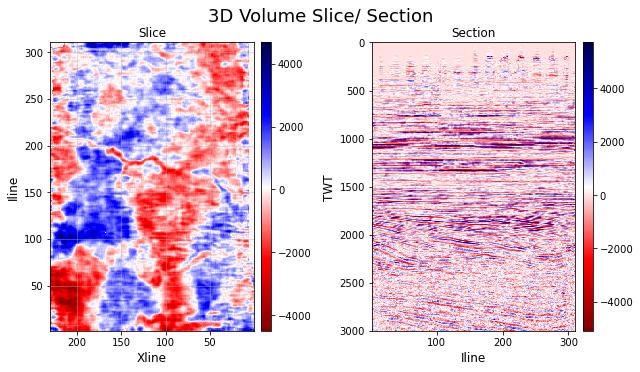

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,5), gridspec_kw={'width_ratios':[4,4]}, constrained_layout=False)
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(xline_3D[:,:,421], iline_3D[:,:,421], signal_3D[:,:,421], shading='auto', cmap='seismic_r')
        ax.set_xlabel('Xline', size=12)
        ax.set_ylabel('Iline', size=12)
        ax.set_title('Slice', size=12)
        ax.invert_xaxis()
        ax.grid(alpha=0.5)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], ax=ax, cax=cax)
    elif i == 1:
        im[i] = ax.pcolormesh(iline_3D[:,110-1,:], twt_3D[:,110-1,:], signal_3D[:,110-1,:], shading='auto', cmap='seismic_r')
        ax.set_xlabel('Iline', size=12)
        ax.set_ylabel('TWT', size=12)
        ax.set_title('Section', size=12)
        ax.invert_yaxis()
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], ax=ax, cax=cax)
fig.text(0.5,1.0, '3D Volume Slice/ Section', ha='center', va='center', size=18)
plt.tight_layout()

### 1D Fast Fourier Transform (FFT)

In [26]:
dt = 0.002  # sample rate
fs = 1/dt  # sample frequency
n = signal.size  # wavelength

#### Complex Transform

In [27]:
from scipy.fft import fft, fftfreq

In [28]:
# frequency
fft_freq = fftfreq(n, dt)  

In [29]:
# FFT of complex signal
fft_signal = fft(signal)

# FFT amplitude
fft_amp = np.abs(fft_signal)

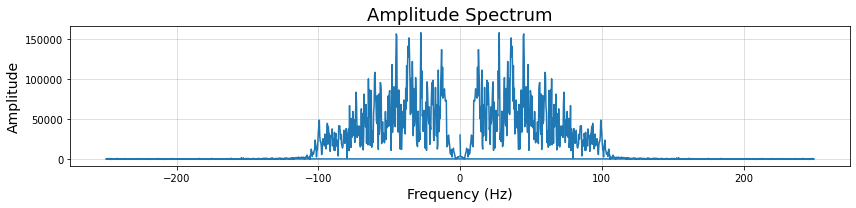

In [30]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(fft_freq, fft_amp)
ax.set_xlabel('Frequency (Hz)', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.set_title('Amplitude Spectrum', size=18)
ax.grid(alpha=0.5)
plt.tight_layout()

#### Real Transform

In [31]:
from scipy.fft import rfft, rfftfreq

In [32]:
# frequency
rfft_freq = rfftfreq(n, dt)

In [33]:
# FFT of real signal
rfft_signal = rfft(signal)

# FFT amplitude
rfft_amp = np.abs(rfft_signal)
rfft_amp_norm = rfft_amp/np.max(rfft_amp)

# FFT power
rfft_pow = rfft_amp**2
rfft_pow_norm = rfft_pow/np.max(rfft_pow)

# FFT Phase
rfft_phase = np.angle(rfft_signal, deg=True)
rfft_phase_rad = np.deg2rad(rfft_phase)

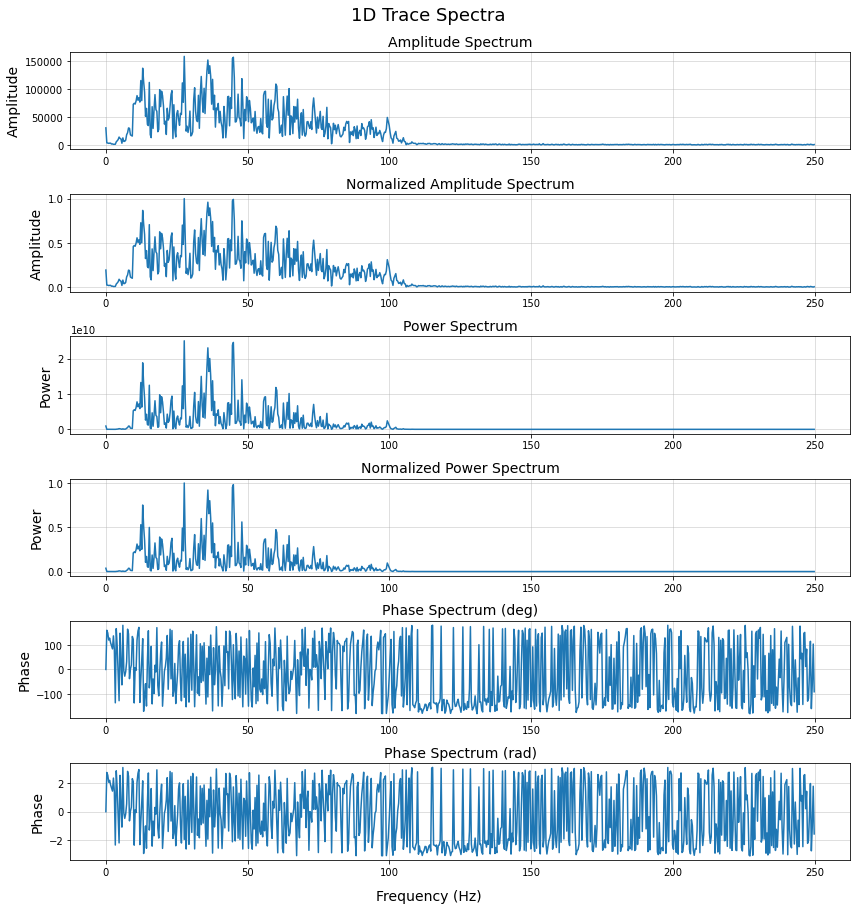

In [34]:
spectra = [rfft_amp,
           rfft_amp_norm,
           rfft_pow,
           rfft_pow_norm,
           rfft_phase,
           rfft_phase_rad]
ylabels = ['Amplitude', 'Amplitude', 
           'Power', 'Power', 
           'Phase', 'Phase']
titles = ['Amplitude Spectrum', 
          'Normalized Amplitude Spectrum', 
          'Power Spectrum', 
          'Normalized Power Spectrum',  
          'Phase Spectrum (deg)', 
          'Phase Spectrum (rad)']

fig, ax = plt.subplots(nrows=6, figsize=(12,12))
for i, ax in enumerate(fig.axes):
    ax.plot(rfft_freq, spectra[i])
    ax.set_ylabel(ylabels[i], size=14)
    ax.set_title(titles[i], size=14)
    ax.grid(alpha=0.5)
fig.text(0.5,-0.01, 'Frequency (Hz)', ha='center', va='center', size=14)
fig.text(0.5,1.01, '1D Trace Spectra', ha='center', va='center', size=18)
plt.tight_layout()

### 2D Fast Fourier Transform (FFT)

In [35]:
from scipy.fft import rfft2

In [36]:
# FFT of real signal
rfft_signal_2D = rfft2(signal_2D)

# FFT amplitude
rfft_amp_2D = np.abs(rfft_signal_2D)
rfft_amp_2D_avg = np.mean(rfft_amp_2D, axis=0)
rfft_amp_2D_avg_norm = rfft_amp_2D_avg/np.max(rfft_amp_2D_avg)

# FFT power
rfft_pow_2D = rfft_amp_2D**2
rfft_pow_2D_avg = np.mean(rfft_pow_2D, axis=0)
rfft_pow_2D_avg_norm = rfft_pow_2D_avg/np.max(rfft_pow_2D_avg)

# FFT Phase
rfft_phase_2D = np.angle(rfft_signal_2D, deg=True)
rfft_phase_2D_avg = np.mean(rfft_phase_2D, axis=0)
rfft_phase_2D_avg_rad = np.deg2rad(rfft_phase_2D_avg)

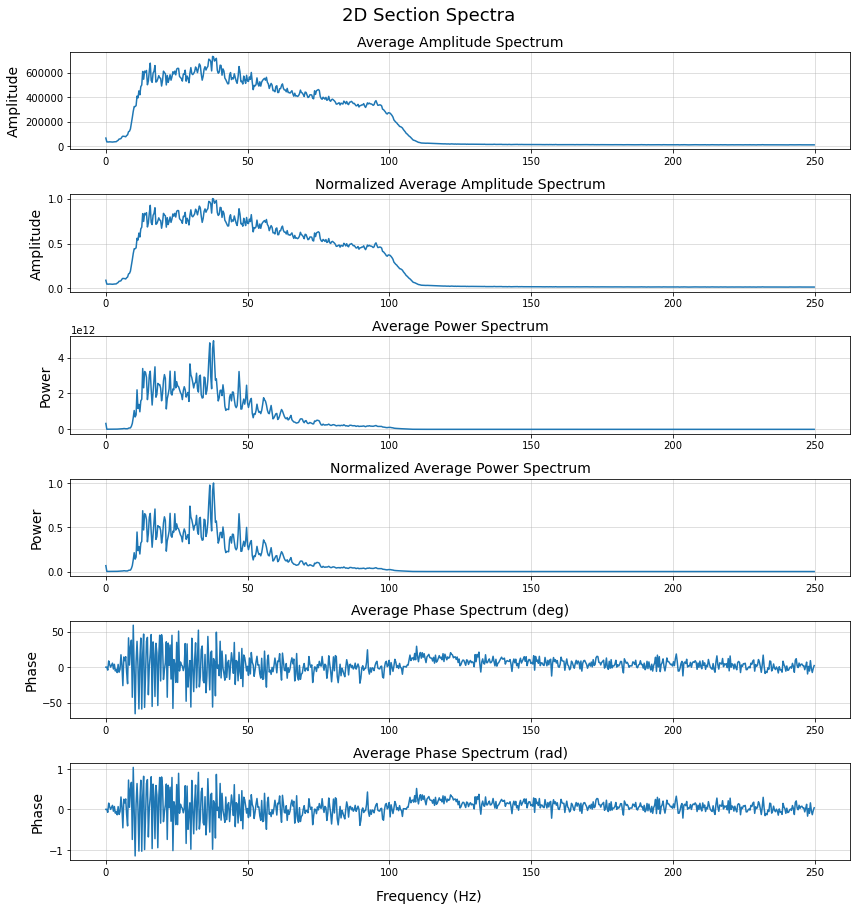

In [37]:
spectra_2D = [rfft_amp_2D_avg,
              rfft_amp_2D_avg_norm,
              rfft_pow_2D_avg,
              rfft_pow_2D_avg_norm,
              rfft_phase_2D_avg,
              rfft_phase_2D_avg_rad]
ylabels = ['Amplitude', 'Amplitude', 
           'Power', 'Power', 
           'Phase', 'Phase']
titles = ['Average Amplitude Spectrum', 
          'Normalized Average Amplitude Spectrum',  
          'Average Power Spectrum', 
          'Normalized Average Power Spectrum',  
          'Average Phase Spectrum (deg)', 
          'Average Phase Spectrum (rad)']

fig, ax = plt.subplots(nrows=6, figsize=(12,12))
for i, ax in enumerate(fig.axes):
    ax.plot(rfft_freq, spectra_2D[i])
    ax.set_ylabel(ylabels[i], size=14)
    ax.set_title(titles[i], size=14)
    ax.grid(alpha=0.5)
fig.text(0.5,-0.01, 'Frequency (Hz)', ha='center', va='center', size=14)
fig.text(0.5,1.01, '2D Section Spectra', ha='center', va='center', size=18)
plt.tight_layout()

#### Most Prominent Spectral Components

In [38]:
from scipy.signal import find_peaks

In [39]:
peaks_2D, peaks_prop_2D = find_peaks(rfft_amp_2D_avg_norm, distance=14, prominence=0.07)

In [40]:
mp_spec_comps_2D = list(rfft_freq[peaks_2D])
mp_spec_comps_2D = [round(i) for i in mp_spec_comps_2D]
mp_spec_comps_2D

[16, 20, 25, 33, 38, 47, 57, 62, 69, 75, 95]

In [41]:
peaks_prop_2D

{'prominences': array([0.25493211, 0.15333498, 0.16093177, 0.18110532, 0.95349711,
        0.19148844, 0.13785625, 0.09594148, 0.07057804, 0.10297292,
        0.07603797]),
 'left_bases': array([  7,  59,  59,  59,   7, 129, 156, 182, 203, 220, 275], dtype=int64),
 'right_bases': array([ 59,  64,  88, 102, 716, 716, 716, 716, 220, 716, 716], dtype=int64)}

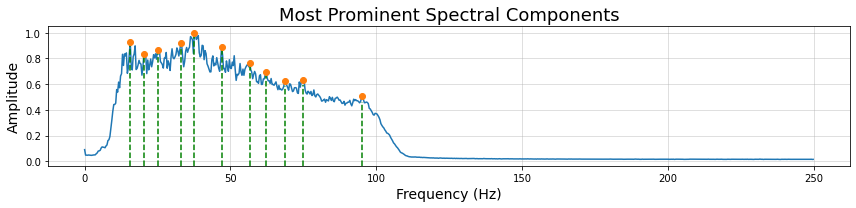

In [42]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(rfft_freq, rfft_amp_2D_avg_norm)
for i in range(len(peaks_2D)):
    ax.axvline(rfft_freq[peaks_2D[i]], ymin=0, ymax=rfft_amp_2D_avg_norm[peaks_2D[i]]-0.05, ls='--', c='g')
ax.plot(rfft_freq[peaks_2D], rfft_amp_2D_avg_norm[peaks_2D], 'o')
ax.set_xlabel('Frequency (Hz)', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.set_title('Most Prominent Spectral Components', size=18)
ax.grid(alpha=0.5)
plt.tight_layout()

#### Peak Spectral Component

In [43]:
amp_mode_2D = np.where(rfft_amp_2D_avg_norm==np.max(rfft_amp_2D_avg_norm))
peak_spec_comp_2D = np.int(np.round(rfft_freq[amp_mode_2D]))
peak_spec_comp_2D

38

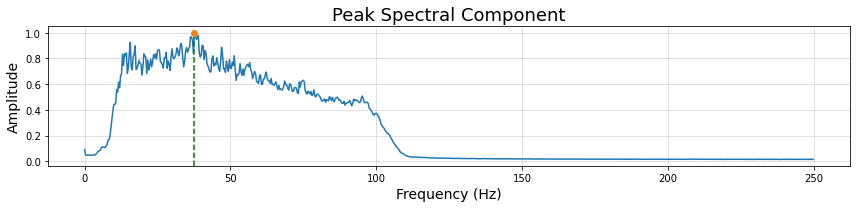

In [44]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(rfft_freq, rfft_amp_2D_avg_norm)
ax.axvline(rfft_freq[amp_mode_2D], ymin=0, ymax=rfft_amp_2D_avg_norm[amp_mode_2D]-0.05, ls='--', c='g')
ax.plot(rfft_freq[amp_mode_2D], rfft_amp_2D_avg_norm[amp_mode_2D], 'o')
ax.set_xlabel('Frequency (Hz)', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.set_title('Peak Spectral Component', size=18)
ax.grid(alpha=0.5)
plt.tight_layout()

### 3D Fast Fourier Transform (FFT)

In [45]:
from scipy.fft import rfftn

In [46]:
# create subvolume (100ms window)
sub_signal_3D = signal_3D[:,:,400:-1050]  # twt 800-900ms

In [47]:
sub_signal_3D.shape

(309, 230, 51)

In [48]:
# frequency (subvolume)
n_3D = sub_signal_3D.shape[-1]
rfft_freq_3D = rfftfreq(n_3D, dt)

In [49]:
# FFT of real signal
rfft_signal_3D = rfftn(sub_signal_3D)

# FFT amplitude
rfft_amp_3D = np.abs(rfft_signal_3D)
rfft_amp_3D_avg = np.mean(rfft_amp_3D, axis=(0,1))
rfft_amp_3D_avg_norm = rfft_amp_3D_avg/np.max(rfft_amp_3D_avg)

# FFT power
rfft_pow_3D = rfft_amp_3D**2
rfft_pow_3D_avg = np.mean(rfft_pow_3D, axis=(0,1))
rfft_pow_3D_avg_norm = rfft_pow_3D_avg/np.max(rfft_pow_3D_avg)

# FFT Phase
rfft_phase_3D = np.angle(rfft_signal_3D, deg=True)
rfft_phase_3D_avg = np.mean(rfft_phase_3D, axis=(0,1))
rfft_phase_3D_avg_rad = np.deg2rad(rfft_phase_3D_avg)

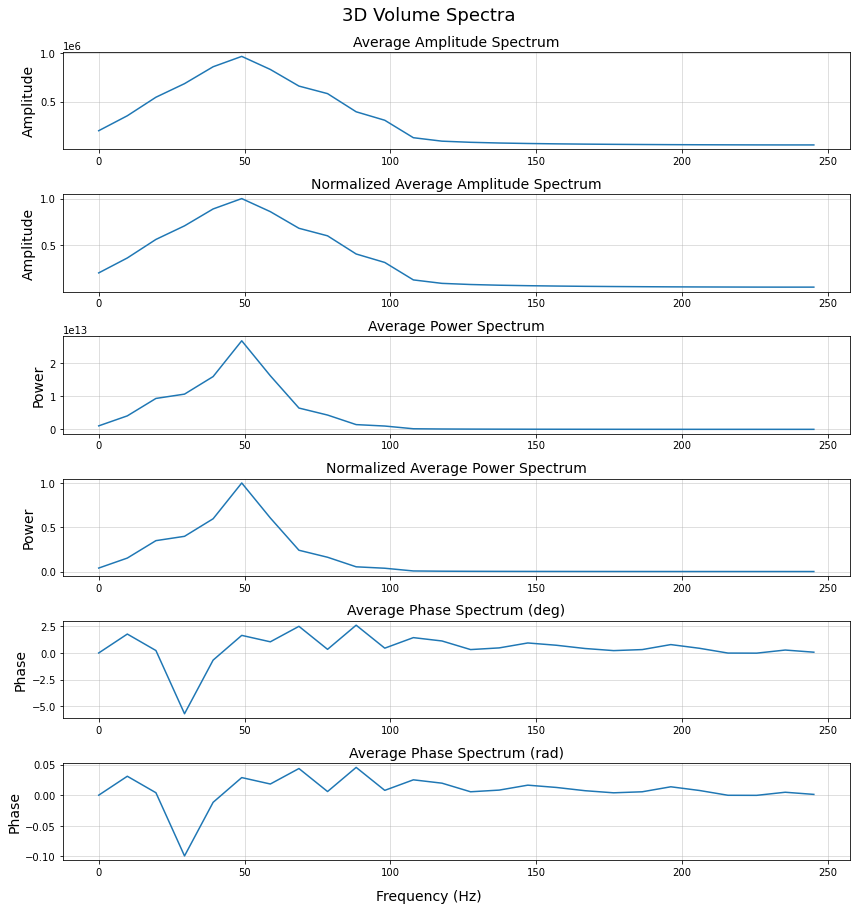

In [50]:
spectra_3D = [rfft_amp_3D_avg,
              rfft_amp_3D_avg_norm,
              rfft_pow_3D_avg,
              rfft_pow_3D_avg_norm,
              rfft_phase_3D_avg,
              rfft_phase_3D_avg_rad]
ylabels = ['Amplitude', 'Amplitude', 
           'Power', 'Power', 
           'Phase', 'Phase']
titles = ['Average Amplitude Spectrum', 
          'Normalized Average Amplitude Spectrum',  
          'Average Power Spectrum', 
          'Normalized Average Power Spectrum',  
          'Average Phase Spectrum (deg)', 
          'Average Phase Spectrum (rad)']

fig, ax = plt.subplots(nrows=6, figsize=(12,12))
for i, ax in enumerate(fig.axes):
    ax.plot(rfft_freq_3D, spectra_3D[i])
    ax.set_ylabel(ylabels[i], size=14)
    ax.set_title(titles[i], size=14)
    ax.grid(alpha=0.5)
fig.text(0.5,-0.01, 'Frequency (Hz)', ha='center', va='center', size=14)
fig.text(0.5,1.01, '3D Volume Spectra', ha='center', va='center', size=18)
plt.tight_layout()

#### Peak Spectral Component

In [51]:
amp_mode_3D = np.where(rfft_amp_3D_avg_norm==np.max(rfft_amp_3D_avg_norm))
peak_spec_comp_3D = np.int(np.round(rfft_freq_3D[amp_mode_3D]))
peak_spec_comp_3D

49

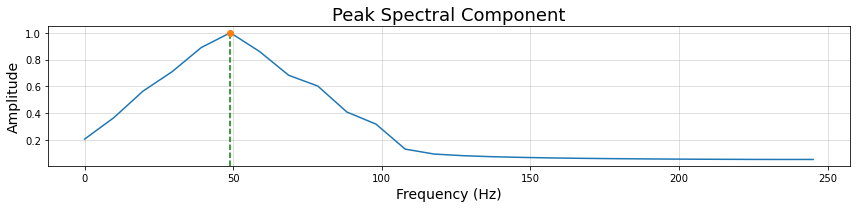

In [52]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(rfft_freq_3D, rfft_amp_3D_avg_norm)
ax.axvline(rfft_freq_3D[amp_mode_3D], ymin=0, ymax=rfft_amp_3D_avg_norm[amp_mode_3D]-0.05, ls='--', c='g')
ax.plot(rfft_freq_3D[amp_mode_3D], rfft_amp_3D_avg_norm[amp_mode_3D], 'o')
ax.set_xlabel('Frequency (Hz)', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.set_title('Peak Spectral Component', size=18)
ax.grid(alpha=0.5)
plt.tight_layout()

#### Low/High Band Spectral Component

In [53]:
freq_std_3D = np.std(rfft_freq_3D)
low_spec_comp_3D = np.int(np.round(peak_spec_comp_3D-freq_std_3D/4))
high_spec_comp_3D = np.int(np.round(peak_spec_comp_3D+freq_std_3D/4))
low_spec_comp_3D, high_spec_comp_3D

(31, 67)

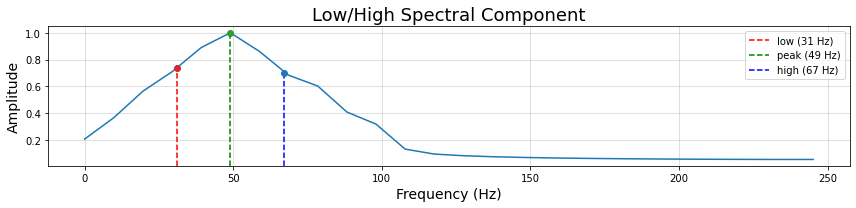

In [54]:
fig, ax = plt.subplots(figsize=(12,3))
psd_freq_3D = np.linspace(0,250,251)
ax.plot(rfft_freq_3D, rfft_amp_3D_avg_norm)

ax.axvline(psd_freq_3D[psd_freq_3D==low_spec_comp_3D], ymax=0.73, ls='--', c='r', label='low (31 Hz)')
ax.plot(psd_freq_3D[psd_freq_3D==low_spec_comp_3D], 0.74, 'o', color='tab:red')

ax.axvline(rfft_freq_3D[amp_mode_3D], ymin=0, ymax=rfft_amp_3D_avg_norm[amp_mode_3D]-0.05, ls='--', c='g', label='peak (49 Hz)')
ax.plot(rfft_freq_3D[amp_mode_3D], rfft_amp_3D_avg_norm[amp_mode_3D], 'o', color='tab:green')

ax.axvline(psd_freq_3D[psd_freq_3D==high_spec_comp_3D], ymax=0.69, ls='--', c='b', label='high (67 Hz)')
ax.plot(psd_freq_3D[psd_freq_3D==high_spec_comp_3D], 0.70, 'o', color='tab:blue')

ax.set_xlabel('Frequency (Hz)', size=14)
ax.set_ylabel('Amplitude', size=14)
ax.set_title('Low/High Spectral Component', size=18)
ax.legend()
ax.grid(alpha=0.5)
plt.tight_layout()

### 1D Short Time Fourier Transform (STFT)

In [55]:
from scipy.signal import stft

In [56]:
stft_freq, stft_time, stft_signal = stft(signal, fs=fs, window='blackman', nperseg=64, noverlap=60, 
                                         boundary='zeros', padded=True, return_onesided=True)

In [57]:
# STFT amplitude
stft_amp = np.abs(stft_signal)

In [58]:
stft_amp.shape

(33, 377)

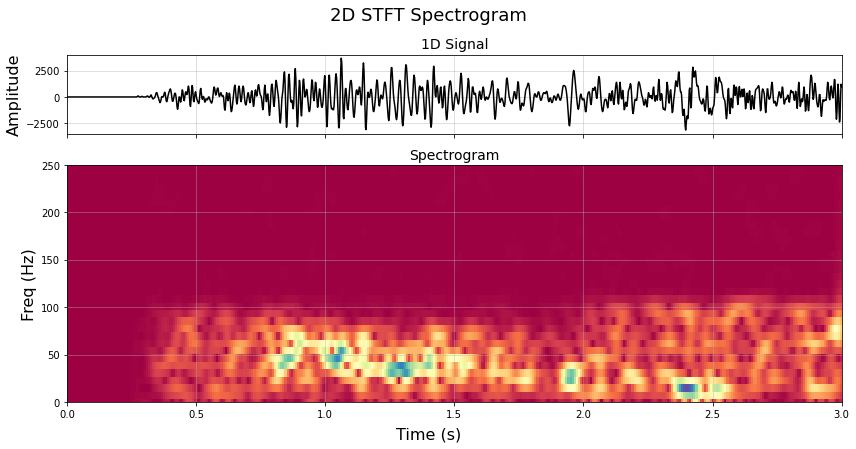

In [59]:
fig, axs = plt.subplots(figsize=(12,6), nrows=2, gridspec_kw={'height_ratios':[1.5,4.5]})
axs[0].plot(time/1e3, signal, color='k')
axs[0].set_xlim([min(time)/1e3, max(time)/1e3])
axs[0].set_ylabel('Amplitude', size=16)
axs[0].set_title('1D Signal', size=14)
axs[0].set_xticklabels([])
axs[0].grid(alpha=0.5)

axs[1].pcolormesh(stft_time, stft_freq, stft_amp, cmap='Spectral', shading='auto')
axs[1].set_xlim([min(time)/1e3, max(time)/1e3])
axs[1].set_ylim([0, fs/2])
axs[1].set_ylabel('Freq (Hz)', size=16)
axs[1].set_title('Spectrogram', size=14)
axs[1].grid(alpha=0.5)
fig.text(0.5,-0.01, 'Time (s)', ha='center', va='center', size=16)
plt.suptitle('2D STFT Spectrogram', size=18)
plt.tight_layout()

In [60]:
sff = np.linspace(0,250,stft_amp.shape[0])
stt = np.linspace(0,3,stft_amp.shape[1])
sFF, sTT = np.meshgrid(sff, stt)

(262.5, -12.5, -0.15000000000000002, 3.15)

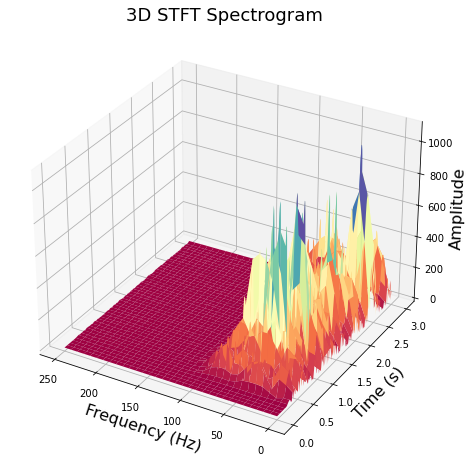

In [61]:
fig = plt.figure(figsize=(8,8)) 
ax = plt.axes(projection='3d')
ax.plot_surface(sFF, sTT, stft_amp.T, cmap='Spectral')
ax.set_xlabel('Frequency (Hz)', size=16)
ax.set_ylabel('Time (s)', size=16)
ax.set_zlabel('Amplitude', size=16)
ax.set_title('3D STFT Spectrogram', size=18)
ax.grid(alpha=0.5)
ax.invert_xaxis()
ax.axis('tight')

### 2D Short Time Fourier Transform (STFT)

In [62]:
from scipy.ndimage import zoom

In [63]:
stft_freq_2D, stft_time_2D, stft_signal_2D = stft(signal_2D, fs=fs, window='blackman', nperseg=64, noverlap=60, 
                                                  boundary='zeros', padded=True, return_onesided=True)

In [64]:
# STFT average amplitude
stft_amp_2D = np.abs(stft_signal_2D)
stft_amp_2D_avg = np.mean(stft_amp_2D, axis=0)

# seismic average ampitude
signal_2D_avg = np.mean(signal_2D, axis=0)

In [65]:
stft_amp_2D.shape, stft_amp_2D_avg.shape, signal_2D_avg.shape

((309, 33, 377), (33, 377), (1501,))

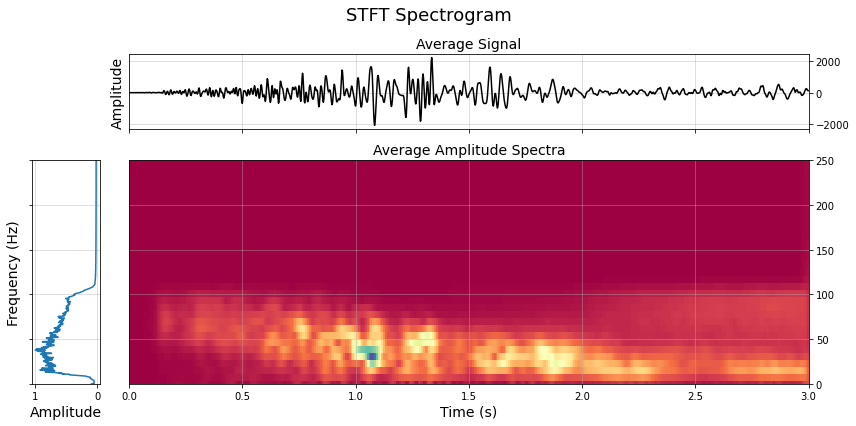

In [66]:
# view average amplitude spectra
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6), gridspec_kw={'height_ratios':[1.5,4.5], 'width_ratios':[1,10]})
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        ax.set_axis_off()
    elif i == 1:
        ax.plot(time/1e3, signal_2D_avg, color='k')
        ax.set_ylabel('Amplitude', size=14)
        ax.yaxis.set_ticks_position('right')
        ax.set_xticklabels([])
        ax.set_xlim([min(time)/1e3, max(time)/1e3])
        ax.set_title('Average Signal', size=14)
        ax.grid(alpha=0.5)
    elif i == 2:
        ax.plot(rfft_amp_2D_avg_norm, rfft_freq)
        ax.set_xlabel('Amplitude', size=14)
        ax.set_ylabel('Frequency (Hz)', size=14)
        ax.set_yticklabels([])
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([np.min(stft_freq_2D), np.max(stft_freq_2D)])
        ax.invert_xaxis()
    else:
        im[i] = ax.pcolormesh(stft_time_2D, stft_freq_2D, stft_amp_2D_avg, cmap='Spectral', shading='auto')
        ax.set_xlabel('Time (s)', size=14)
        ax.yaxis.set_ticks_position('right')
        ax.set_xlim([min(time)/1e3, max(time)/1e3])
        ax.set_ylim([np.min(stft_freq_2D), np.max(stft_freq_2D)])
        ax.set_title('Average Amplitude Spectra', size=14)
    ax.grid(alpha=0.5)
plt.suptitle('STFT Spectrogram', size=18)
plt.tight_layout()

In [67]:
# resize frequency and time axes of the 2D section
spec_mag_2D = stft_amp_2D
spec_mag_2D = zoom(spec_mag_2D, [1, 250/spec_mag_2D.shape[1], 1501/spec_mag_2D.shape[2]])

In [68]:
spec_mag_2D.shape

(309, 250, 1501)

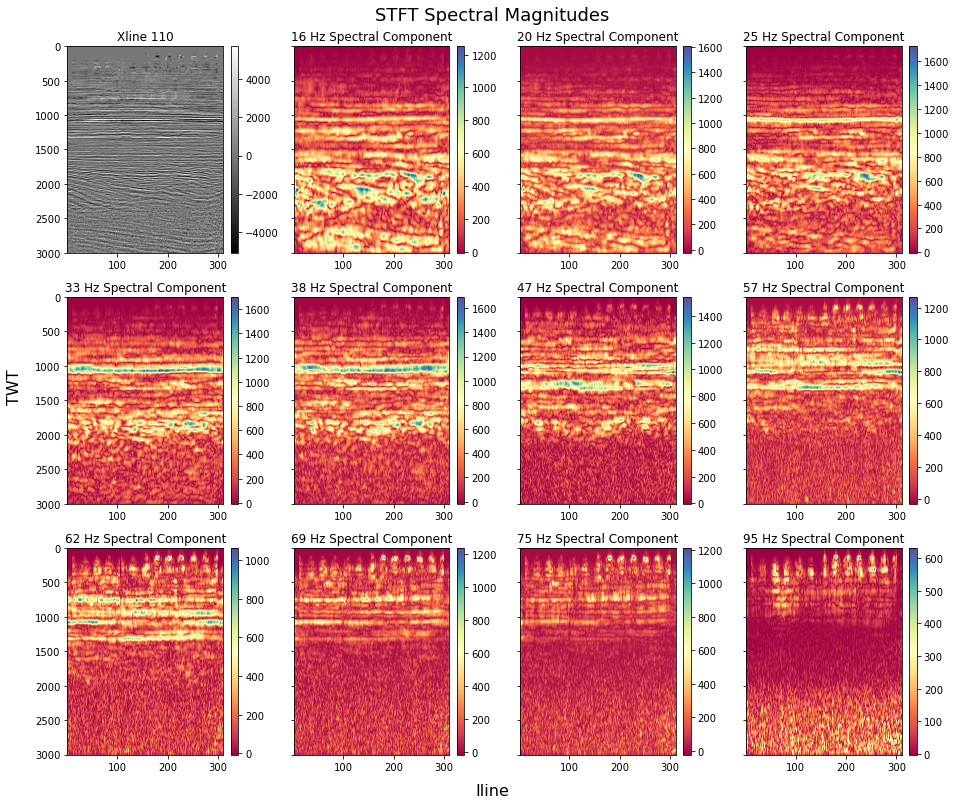

In [69]:
# compare spectral magnitude of most prominent spectral components
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(13,11), sharey=True, constrained_layout=False)
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(iline_2D, twt_2D, signal_2D, shading='auto', cmap='gray', 
                              vmin=np.min(signal_2D), vmax=np.max(signal_2D))
        ax.set_title('Xline 110', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    else:
        im[i] = ax.pcolormesh(iline_2D, twt_2D, spec_mag_2D[:,mp_spec_comps_2D[i-1]-1,:], 
                              shading='auto', cmap='Spectral', 
                              vmin=np.min(spec_mag_2D[:,mp_spec_comps_2D[i-1]-1,:]), 
                              vmax=np.max(spec_mag_2D[:,mp_spec_comps_2D[i-1]-1,:]))
        ax.set_title('%s' %'{} Hz Spectral Component'.format(mp_spec_comps_2D[i-1]), size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
ax.invert_yaxis()
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
plt.suptitle('STFT Spectral Magnitudes', size=18)
plt.tight_layout()

#### Seismic Attributes

Instanteneous amplitude (trace envelope or reflection strength) = |C| = sqrt(R** 2 + I** 2) 

Instanteneous phase (rotation angle) = arctan(I/R)

Instanteneous frequency = dphi/dt = d(arctan(I/R))/dt = (R*(dI/dt) - I*(dR/dt))/(R** 2 + I** 2)

where: 

C- complex or analytical trace

R- real or seismic trace 

I- imaginary or hilbert trace

t- time

Response attributes are computed at the peaks of the instantaneous amplitude (envelope) between two troughs.

In [70]:
from scipy import ndimage
from scipy.signal import hilbert, argrelmin

In [71]:
# create complex trace attributes function
def traces_2D(real, dt):
    
    # signal components
    R_trace = real
    C_trace = hilbert(R_trace, axis=-1)
    I_trace = np.imag(C_trace)
        
    # instantaneous attributes
    env = np.abs(C_trace)  # envelope
    phase = np.rad2deg(np.angle(C_trace))  # phase
    freq = np.abs((1/(2*np.pi))*(np.gradient(np.unwrap(np.deg2rad(phase)), dt, axis=-1)))  # frequency
    
    # rac = np.gradient(env, dt, axis=-1)/env  # relative amplitude change
    # band = (1/(2*np.pi))*np.abs(rac)  # instantaneous bandwidth
    # dom_freq = np.hypot(freq, band)  # dominant frequency
    # sweet = env/np.sqrt(dom_freq)  # sweetness
    
    def rms(real):
        rms = np.sqrt(np.mean(real**2))
        return rms
    
    rms_env = ndimage.generic_filter(env, rms, size=(3,3), mode='reflect')  # root mean square envelope
    med_phase = ndimage.median_filter(phase, size=(3,3), mode='reflect')  # median filtered phase
    med_freq = ndimage.median_filter(freq, size=(3,3), mode='reflect')  # median filtered frequency
    
    # create a boolean array of trough locations
    troughs_idx = argrelmin(env, axis=-1, order=1, mode='clip')
    troughs = np.zeros(env.shape, dtype=bool)
    troughs[troughs_idx] = True
    troughs = np.cumsum(troughs, axis=-1)
    
    def response(envelope, real, phase, freq, troughs):
        # response attributes
        resp_env = np.zeros(envelope.shape)
        resp_phase = np.zeros(envelope.shape)
        resp_freq = np.zeros(envelope.shape)
        app_pol = np.zeros(envelope.shape)
        
        for i in np.ndindex(envelope.shape[:-1]):
            # unique classes (True or False)
            ints = np.unique(troughs[i, :])
            
            for ii in ints:
                idx = np.where(troughs[i, :] == ii)[1]
                peak = idx[envelope[i, idx].argmax()]
                
                resp_env[i, idx] = envelope[i, peak]  # response envelope
                resp_phase[i, idx] = phase[i, peak]  # response phase
                resp_freq[i, idx] = freq[i, peak]  # response frequency
                app_pol[i, idx] = envelope[i, peak] * np.sign(real[i, peak]) # apparent polarity
                
        return resp_env, resp_phase, resp_freq, app_pol
    
    resp_env, resp_phase, resp_freq, app_pol = response(env, R_trace, phase, freq, troughs)
    
    return env, phase, freq, resp_env, resp_phase, resp_freq, rms_env, med_phase, med_freq

In [72]:
# create edge detection attributes function
def edges_2D(data, zwin, window):
    
    # # crosscorrelation based coherence
    # corr_coh_2D = np.zeros_like(data)
    # nx, nz = data.shape
    # # pad data by reflecting boundary
    # padded = np.pad(data, ((0, 1), (zwin//2, zwin//2)), mode='reflect')
    
    # for x, z, in np.ndindex(nx, nz):
        # center_trace = data[x, :]  # center trace (full length of time axis)   
        # x_trace = padded[x+1, z:z+zwin]  # adjacent traces (moving window along time axis)
        # # cross correlate (output length = center_trace.size - x_trace.size + 1)
        # xcorr = np.correlate(center_trace, x_trace)
        # # maximum normalized cross correlation value
        # center_std = center_trace.std()
        # x_std = x_trace.std()
        # px = xcorr.max() / (xcorr.size * center_std * x_std)
        # corr_coh_2D[x,z] = px  # normalized crosscorrelation based coherence

    # corr_coh_2D = np.clip(corr_coh_2D, a_min=0, a_max=1)
    # corr_coh_2D = np.nan_to_num(corr_coh_2D, nan=0, posinf=1, neginf=0)
    
    # semblance based coherence
    def sembl_func(region):
        # reshape 1D generic filter input to window shape
        region = region.reshape(window)
        # reshape window to 2D array (ntraces by nsamples)
        region = region.reshape(-1, region.shape[-1])
        ntraces, nsamples = region.shape
        
        # in terms of energy ratio
        square_of_sums = np.sum(region, axis=0)**2
        sum_of_squares = np.sum(region**2, axis=0)
        sembl = square_of_sums.sum() / sum_of_squares.sum()
        
        # alternatively in terms of covariance matrix
        # cov = region.dot(region.T)
        # sembl = cov.sum() / cov.diagonal().sum()
        
        return sembl / ntraces
    
    # semblance is sensitive to amplitude and phase changes (better for stratigraphy)
    sembl_coh = ndimage.generic_filter(data, sembl_func, window)  # semblance based coherence
    sembl_coh[np.isnan(sembl_coh)] = 0
        
    # eigenstructure based coherence
    def eigenstruc_func(region):
        # reshape 1D generic filter input to window shape
        region = region.reshape(window)
        # reshape window to 2D array (ntraces by nsamples)
        region = region.reshape(-1, region.shape[-1])
        
        # ratio of the largest eigenvalue to sum of eigenvalues
        cov = region.dot(region.T)
        vals = np.linalg.eigvalsh(cov)
        eigenstruc = vals.max() / vals.sum()
        
        return eigenstruc
    
    # eigenstructure is sensitive only to phase changes (better for subtle structures)
    eigenstruc_coh = ndimage.generic_filter(data, eigenstruc_func, window)  # eigenstructure based coherence
    eigenstruc_coh[np.isnan(eigenstruc_coh)] = 0
    
    # # gradient magnitude
    # gauss_gdmg = ndimage.gaussian_gradient_magnitude(data, sigma=(1,1), mode='reflect')  
    # gauss_gdmg = gauss_gdmg/np.max(gauss_gdmg)  # normalized gaussian gradient magnitude
    
    return sembl_coh, eigenstruc_coh

In [73]:
# compute complex trace attributes
trace_attributes_2D = traces_2D(signal_2D, dt)

# compute edge detection attributes
edge_attributes_2D = edges_2D(signal_2D, zwin=None, window=(3,9))

In [74]:
edge_cmaps = ['gray', 'gray']
trace_cmaps = ['jet', 'hsv', 'gist_rainbow', 'jet', 'hsv', 'gist_rainbow', 'jet', 'hsv', 'gist_rainbow']

edge_titles = ['Semblance Based Coherence', 'Eigenstructure Based Coherence']
trace_titles = ['Trace Envelope', 'Instantaneous Phase', 'Intantaneous Frequency', 
                'Response Envelope', 'Response Phase', 'Response Frequency', 
                'RMS Envelope', 'Median Filtered Phase', 'Median Filtered Frequency']

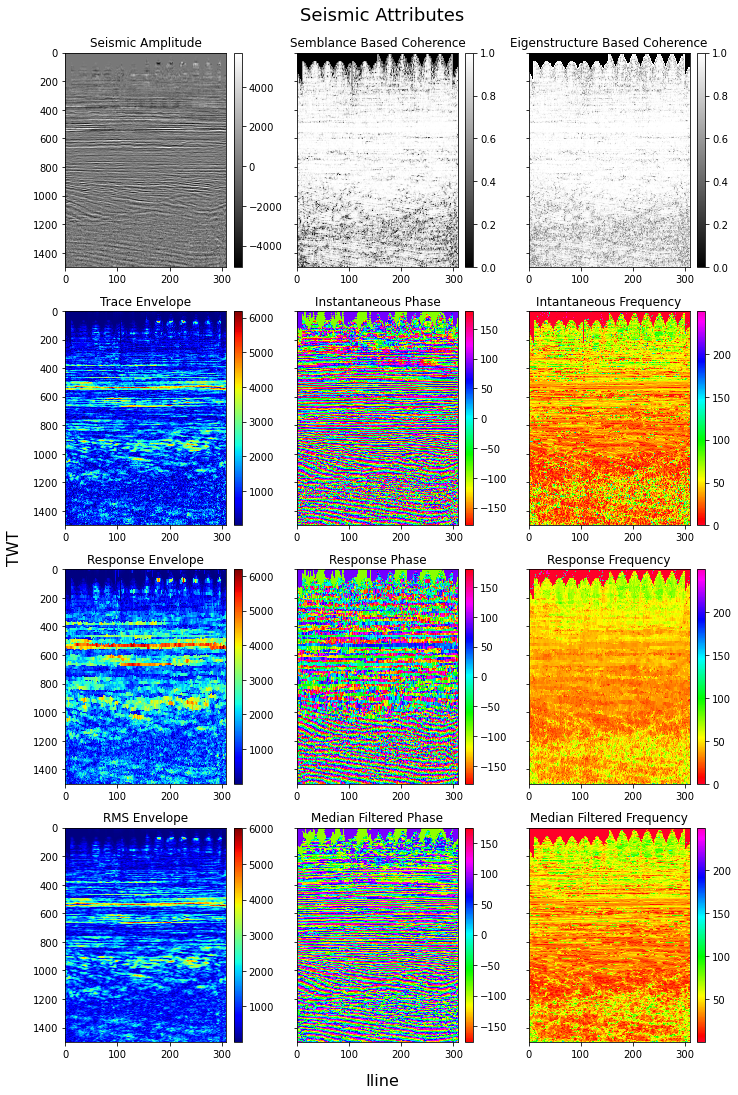

In [75]:
# view seismic attributes
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,14.5), sharey=True, constrained_layout=False)
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(signal_2D.T, shading='auto', cmap='gray', 
                              vmin=np.percentile(signal_2D, 0), 
                              vmax=np.percentile(signal_2D, 100))
        ax.set_title('Seismic Amplitude', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i in [1,2]:
        im[i] = ax.pcolormesh(edge_attributes_2D[i-1].T, shading='auto', cmap=edge_cmaps[i-1], 
                              vmin=np.percentile(edge_attributes_2D[i-1], 0), 
                              vmax=np.percentile(edge_attributes_2D[i-1], 100))
        ax.set_title(edge_titles[i-1], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    else:
        im[i] = ax.pcolormesh(trace_attributes_2D[i-3].T, shading='auto', cmap=trace_cmaps[i-3], 
                              vmin=np.percentile(trace_attributes_2D[i-3], 0), 
                              vmax=np.percentile(trace_attributes_2D[i-3], 100))
        ax.set_title(trace_titles[i-3], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
ax.invert_yaxis()
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Seismic Attributes', ha='center', va='center', size=18)
plt.tight_layout()

#### Principal Components

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [77]:
# rehsape spectral maginitudes to 1D
mp_spec_m_2D = [i for i in range(len(mp_spec_comps_2D))]

for i in range(len(mp_spec_comps_2D)):
    mp_spec_m_2D[i] = spec_mag_2D[:,mp_spec_comps_2D[i]-1,:].reshape(-1)

In [78]:
# convert to dataframe
mp_spec_m_2D_df = pd.DataFrame(np.asarray(mp_spec_m_2D).T, columns=mp_spec_comps_2D)
mp_spec_m_2D_df

16            20            25            33            38  \
0      -3.435974e-29 -1.263378e-29  2.263804e-29 -8.770077e-30 -2.210062e-29   
1      -7.224927e-20 -7.754197e-20 -7.641356e-20 -6.028213e-20 -4.479657e-20   
2      -1.923219e-19 -2.064107e-19 -2.034069e-19 -1.604663e-19 -1.192450e-19   
3      -2.152051e-19 -2.309702e-19 -2.276091e-19 -1.795592e-19 -1.334332e-19   
4       4.113721e-21  4.415077e-21  4.350827e-21  3.432337e-21  2.550622e-21   
...              ...           ...           ...           ...           ...   
463804  1.227128e+02  1.338948e+02  1.369153e+02  1.366436e+02  1.510768e+02   
463805  1.104166e+02  1.220884e+02  1.278063e+02  1.310528e+02  1.434594e+02   
463806  9.863198e+01  1.104828e+02  1.182630e+02  1.245254e+02  1.351671e+02   
463807  8.978329e+01  1.016403e+02  1.107383e+02  1.191082e+02  1.285030e+02   
463808  8.629497e+01  9.812344e+01  1.076850e+02  1.168476e+02  1.257698e+02   

                  47            57            62            69            75  \
0      -5.711952e-30  2.204969e-29 -4.383830e-30  9.681311e-30  1.644665e-29   
1      -1.508694e-20  2.967764e-22  4.368592e-21  1.586196e-20  1.485183e-20   
2      -4.016025e-20  7.899957e-22  1.162885e-20  4.222329e-20  3.953440e-20   
3      -4.493867e-20  8.839924e-22  1.301250e-20  4.724719e-20  4.423836e-20   
4       8.590185e-22 -1.689782e-23 -2.487384e-22 -9.031465e-22 -8.456317e-22   
...              ...           ...           ...           ...           ...   
463804  1.801063e+02  1.454884e+02  1.080400e+02  1.064852e+02  1.263244e+02   
463805  1.667928e+02  1.365157e+02  1.069175e+02  1.034171e+02  1.154745e+02   
463806  1.532483e+02  1.274354e+02  1.045932e+02  9.950037e+01  1.050601e+02   
463807  1.427317e+02  1.204051e+02  1.022969e+02  9.612849e+01  9.723318e+01   
463808  1.385019e+02  1.175823e+02  1.012581e+02  9.469489e+01  9.414597e+01   

                  95  
0       2.715775e-29  
1       4.106369e-20  
2       1.093083e-19  
3       1.223143e-19  
4      -2.338080e-21  
...              ...  
463804  3.254848e+01  
463805  3.474586e+01  
463806  3.654758e+01  
463807  3.776613e+01  
463808  3.821398e+01  

[463809 rows x 11 columns]

In [79]:
# normalize spectral magnitudes
scaled_mp_spec_m_2D = MinMaxScaler().fit_transform(mp_spec_m_2D_df)

In [80]:
# check PCA statistics
pca_m_2D = PCA(n_components=11).fit(scaled_mp_spec_m_2D)
pca_attributes_m_2D = pd.DataFrame(np.asarray([pca_m_2D.explained_variance_ratio_, 
                                               np.cumsum(pca_m_2D.explained_variance_ratio_), 
                                               pca_m_2D.singular_values_, 
                                               np.cumsum(pca_m_2D.singular_values_)]).T, 
                                   columns=['explained_variance_ratio', 'cumulative', 'singular_values', 'cumulative'])
pca_attributes_m_2D.index = ['PC{}'.format(i) for i in range(1,len(mp_spec_m_2D)+1)]
pca_attributes_m_2D

explained_variance_ratio  cumulative  singular_values  cumulative
PC1                   0.449844    0.449844       198.851944  198.851944
PC2                   0.248012    0.697856       147.650406  346.502350
PC3                   0.130676    0.828531       107.175583  453.677917
PC4                   0.068167    0.896699        77.408195  531.086121
PC5                   0.046925    0.943623        64.224243  595.310364
PC6                   0.026797    0.970420        48.533337  643.843689
PC7                   0.018444    0.988864        40.264908  684.108582
PC8                   0.006748    0.995612        24.355114  708.463684
PC9                   0.003358    0.998971        17.181847  725.645508
PC10                  0.000932    0.999903         9.051398  734.696899
PC11                  0.000097    1.000000         2.921528  737.618408

In [81]:
# extract first three principal components of spectral magnitudes
PC_mp_spec_m_2D = PCA(n_components=3).fit_transform(scaled_mp_spec_m_2D)

In [82]:
PC_mp_spec_m_2D_lst = np.hsplit(PC_mp_spec_m_2D, indices_or_sections=PC_mp_spec_m_2D.shape[-1])
PC_mp_spec_m_2D_lst = [item.reshape(signal_2D.shape) for item in PC_mp_spec_m_2D_lst]

In [83]:
PC_titles = ['PC1', 'PC2', 'PC3']

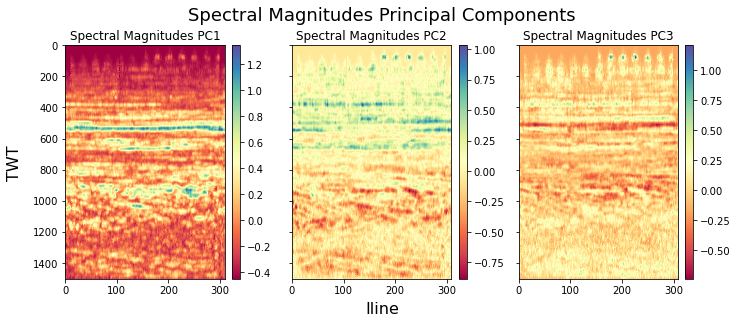

In [84]:
# view spectral magnitudes principal components
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,4), sharey=True, constrained_layout=False)
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    im[i] = ax.pcolormesh(PC_mp_spec_m_2D_lst[i].T, shading='auto', cmap='Spectral', 
                          vmin=np.percentile(PC_mp_spec_m_2D_lst[i], 0), 
                          vmax=np.percentile(PC_mp_spec_m_2D_lst[i], 100))
    ax.set_title('Spectral Magnitudes ' + PC_titles[i], size=12)
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im[i], cax=cax, ax=ax)
ax.invert_yaxis()
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Spectral Magnitudes Principal Components', ha='center', va='center', size=18)
plt.tight_layout()

In [85]:
# compute spectral magnitudes PC1 complex trace attributes
PC1_mp_spec_m_trace_attributes_2D = traces_2D(PC_mp_spec_m_2D_lst[0], dt)

# compute spectral magnitudes PC1 edge detection attributes
PC1_mp_spec_m_edge_attributes_2D = edges_2D(PC_mp_spec_m_2D_lst[0], zwin=None, window=(3,9))

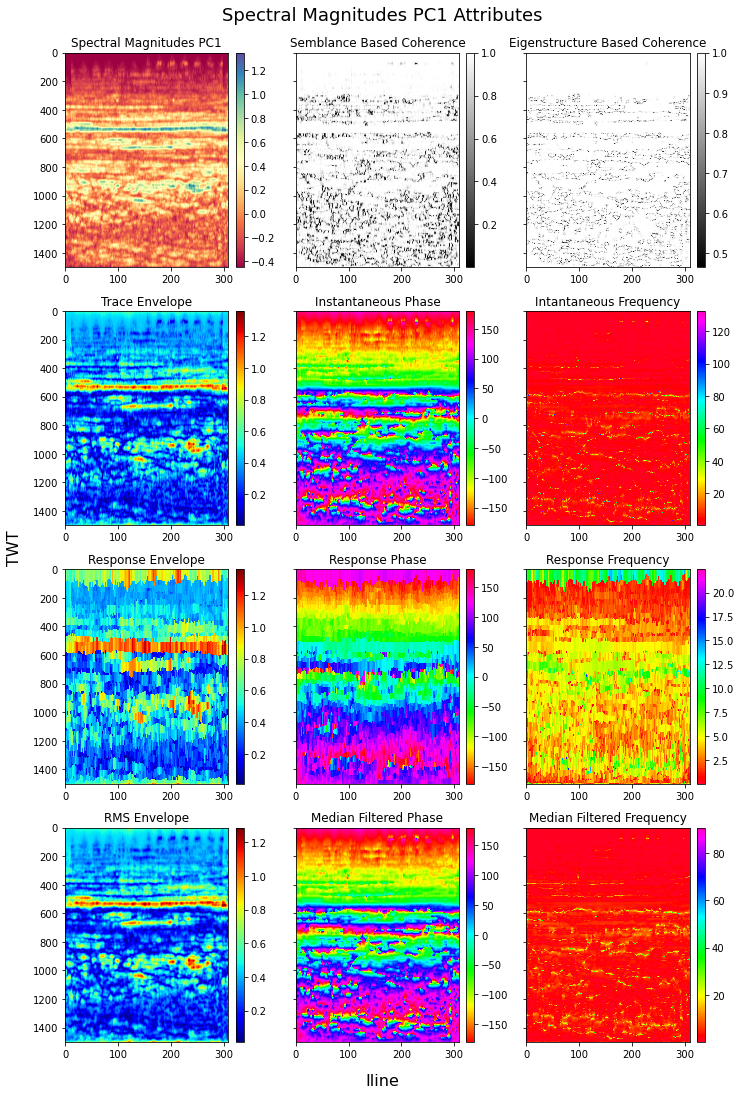

In [86]:
# view spectral magnitudes PC1 attributes
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,14.5), sharey=True, constrained_layout=False)
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(PC_mp_spec_m_2D_lst[0].T, shading='auto', cmap='Spectral', 
                              vmin=np.percentile(PC_mp_spec_m_2D_lst[0], 0), 
                              vmax=np.percentile(PC_mp_spec_m_2D_lst[0], 100))
        ax.set_title('Spectral Magnitudes PC1', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i in [1,2]:
        im[i] = ax.pcolormesh(PC1_mp_spec_m_edge_attributes_2D[i-1].T, shading='auto', cmap=edge_cmaps[i-1], 
                              vmin=np.percentile(PC1_mp_spec_m_edge_attributes_2D[i-1], 0), 
                              vmax=np.percentile(PC1_mp_spec_m_edge_attributes_2D[i-1], 100))
        ax.set_title(edge_titles[i-1], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    else:
        im[i] = ax.pcolormesh(PC1_mp_spec_m_trace_attributes_2D[i-3].T, shading='auto', cmap=trace_cmaps[i-3], 
                              vmin=np.percentile(PC1_mp_spec_m_trace_attributes_2D[i-3], 0), 
                              vmax=np.percentile(PC1_mp_spec_m_trace_attributes_2D[i-3], 100))
        ax.set_title(trace_titles[i-3], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
ax.invert_yaxis()
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Spectral Magnitudes PC1 Attributes', ha='center', va='center', size=18)
plt.tight_layout()

#### RGBA Color Blending

Color = Red + Green + Blue

Opacity = Alpha

R(0) + B(0) + G(0) = Black

R(127) + B(127) + G(127) = Gray

R(255) + B(255) + G(255) = White

In [87]:
from matplotlib.colors import LinearSegmentedColormap

In [88]:
# check scale and data type
np.min(PC_mp_spec_m_2D_lst[0]), np.max(PC_mp_spec_m_2D_lst[0]), PC_mp_spec_m_2D_lst[0].dtype

(-0.4488074, 1.3473821, dtype('float32'))

In [89]:
# create function for grayscale conversion
def grayscale(data, mn, mx):
    return (data-mn)/(mx-mn)*255

In [90]:
# convert to grayscale
PC_mp_spec_m_2D_lst_gray = [i for i in range(len(PC_mp_spec_m_2D_lst))]

for i in range(len(PC_mp_spec_m_2D_lst)):
    PC_mp_spec_m_2D_lst_gray[i] = grayscale(PC_mp_spec_m_2D_lst[i], 
                                            np.min(PC_mp_spec_m_2D_lst[i]), 
                                            np.max(PC_mp_spec_m_2D_lst[i]))
    
sembl_based_coh_2D_gray = grayscale(edge_attributes_2D[0], 
                                    np.min(edge_attributes_2D[0]), 
                                    np.max(edge_attributes_2D[0]))

# convert to 8-bit unsigned integer
PC_mp_spec_m_2D_lst_gray = np.uint8(PC_mp_spec_m_2D_lst_gray)

sembl_based_coh_2D_gray = np.uint8(sembl_based_coh_2D_gray)

In [91]:
# check new scale and data type
np.min(PC_mp_spec_m_2D_lst_gray[0]), np.max(PC_mp_spec_m_2D_lst_gray[0]), PC_mp_spec_m_2D_lst_gray[0].dtype

(0, 255, dtype('uint8'))

In [92]:
# stack principal components in RGB channels
PC_mp_spec_m_2D_stack = np.dstack(PC_mp_spec_m_2D_lst_gray)

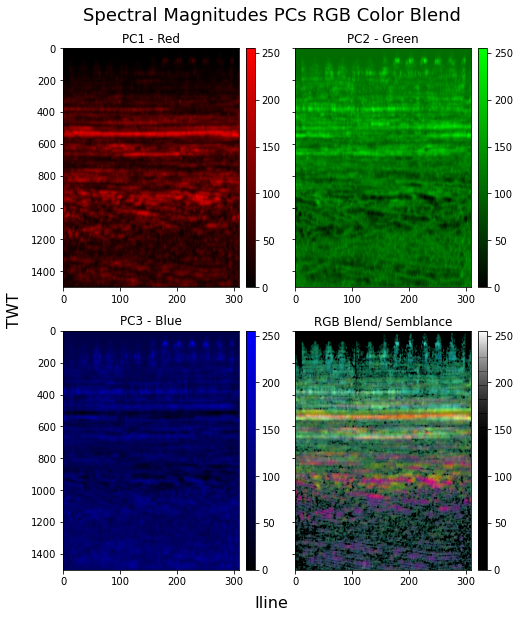

In [93]:
# view RGB principal components blend
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,8), sharey=True)
cmap_r = LinearSegmentedColormap.from_list(name='r', colors=[(0,0,0,1), (1,0,0,1)])
cmap_g = LinearSegmentedColormap.from_list(name='g', colors=[(0,0,0,1), (0,1,0,1)])
cmap_b = LinearSegmentedColormap.from_list(name='b', colors=[(0,0,0,1), (0,0,1,1)])
cmap_a = LinearSegmentedColormap.from_list(name='a', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,0)])
for i, ax in enumerate(fig.axes):
    if i == 0: 
        im = ax.imshow(PC_mp_spec_m_2D_lst_gray[0].T, cmap=cmap_r, aspect='auto', vmin=0, vmax=255)
        ax.set_title('%s' %PC_titles[i] + ' - Red', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, ax=ax, orientation='vertical')
    elif i == 1: 
        im = ax.imshow(PC_mp_spec_m_2D_lst_gray[1].T, cmap=cmap_g, aspect='auto', vmin=0, vmax=255)
        ax.set_title('%s' %PC_titles[i] + ' - Green', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, ax=ax, orientation='vertical')
    elif i == 2: 
        im = ax.imshow(PC_mp_spec_m_2D_lst_gray[2].T, cmap=cmap_b, aspect='auto', vmin=0, vmax=255)
        ax.set_title('%s' %PC_titles[i] + ' - Blue', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, ax=ax, orientation='vertical')
    else:
        im = ax.imshow(PC_mp_spec_m_2D_stack.transpose(1,0,2), aspect='auto', vmin=0, vmax=255)
        ax.set_title('RGB Blend/ Semblance', size=12)
        im2 = ax.imshow(sembl_based_coh_2D_gray.T, cmap=cmap_a, aspect='auto', vmin=0, vmax=255)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im2, cax=cax, ax=ax, orientation='vertical')
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Spectral Magnitudes PCs RGB Color Blend', ha='center', va='center', size=18)
plt.tight_layout()

#### Peak Component

In [94]:
# extract peak spectral magnitude
peak_spec_m_2D = spec_mag_2D[:,peak_spec_comp_2D-1,:]

In [95]:
# compute peak spectral magnitude complex trace attributes
peak_spec_m_trace_attributes_2D = traces_2D(peak_spec_m_2D, dt)

# compute peak spectral magnitude edge detection attributes
peak_spec_m_edge_attributes_2D = edges_2D(peak_spec_m_2D, zwin=None, window=(3,9))

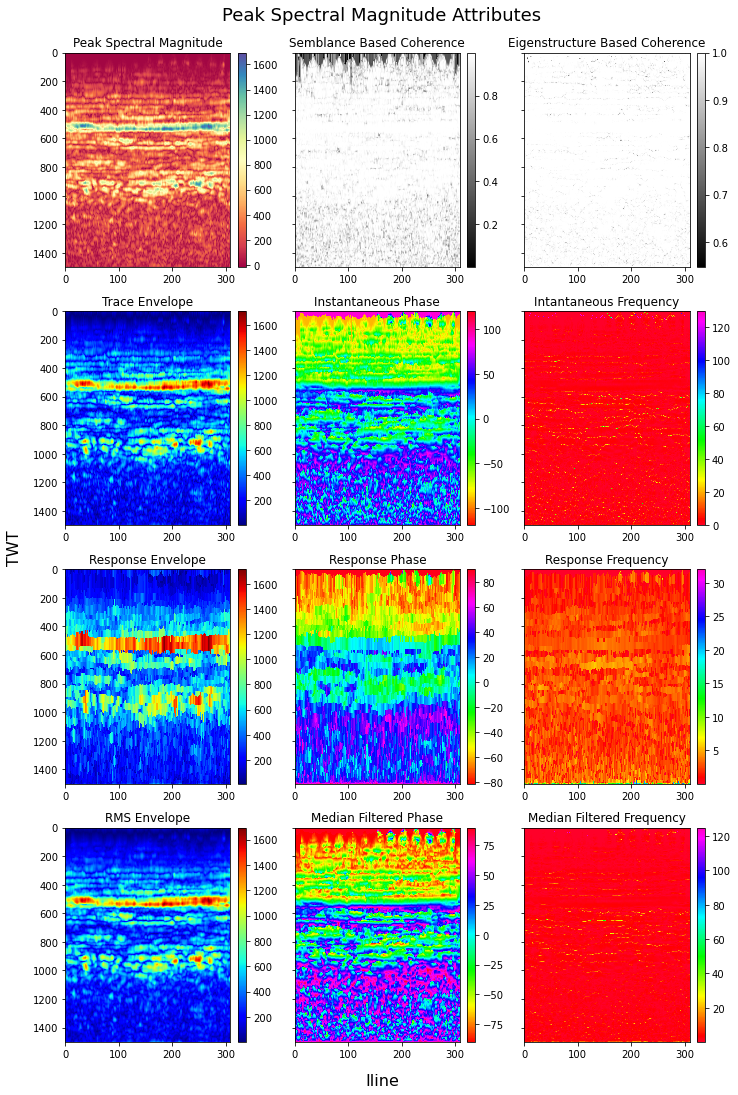

In [96]:
# view peak spectral magnitude attributes
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,14.5), sharey=True, constrained_layout=False)
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(peak_spec_m_2D.T, shading='auto', cmap='Spectral', 
                              vmin=np.percentile(peak_spec_m_2D, 0), 
                              vmax=np.percentile(peak_spec_m_2D, 100))
        ax.set_title('Peak Spectral Magnitude', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i in [1,2]:
        im[i] = ax.pcolormesh(peak_spec_m_edge_attributes_2D[i-1].T, shading='auto', cmap=edge_cmaps[i-1], 
                              vmin=np.percentile(peak_spec_m_edge_attributes_2D[i-1], 0), 
                              vmax=np.percentile(peak_spec_m_edge_attributes_2D[i-1], 100))
        ax.set_title(edge_titles[i-1], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    else:
        im[i] = ax.pcolormesh(peak_spec_m_trace_attributes_2D[i-3].T, shading='auto', cmap=trace_cmaps[i-3], 
                              vmin=np.percentile(peak_spec_m_trace_attributes_2D[i-3], 0), 
                              vmax=np.percentile(peak_spec_m_trace_attributes_2D[i-3], 100))
        ax.set_title(trace_titles[i-3], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
ax.invert_yaxis()
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Peak Spectral Magnitude Attributes', ha='center', va='center', size=18)
plt.tight_layout()

#### HSL Corendering

Hue - Peak Spectral Phase/Frequency: H = P or F

Saturation - Peak Spectral Magnitude: S = 100 * (M / M_max)

Lightness - Crosscorrelation Based Coherence: L = (C * L_min) + ((1 - C) * L_max)

where:

P = phase

F = frequency

M = magnitude

M_max = maximum magnitude

C = coherence

L_min = threshold minimum coherence

L_max = threshold maximum coherence

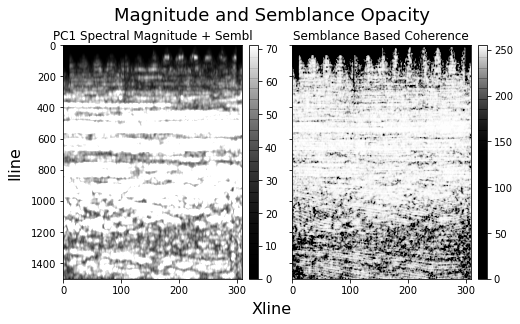

In [97]:
# set opacity range for magnitude and semblance
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)
cmap_m = LinearSegmentedColormap.from_list(name='m', colors=[(0,0,0,1), (0,0,0,0)])
cmap_l = LinearSegmentedColormap.from_list(name='l', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,0)])

im1 = ax[0].imshow(PC_mp_spec_m_2D_lst_gray[0].T, cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[0].set_title('PC1 Spectral Magnitude + Sembl', size=12)
cax = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, ax=ax)

im2 = ax[1].imshow(sembl_based_coh_2D_gray.T, cmap=cmap_l, aspect='auto', vmin=0, vmax=255)
ax[1].set_title('Semblance Based Coherence', size=12)
cax = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, ax=ax)

fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Magnitude and Semblance Opacity', ha='center', va='center', size=18)
plt.tight_layout()

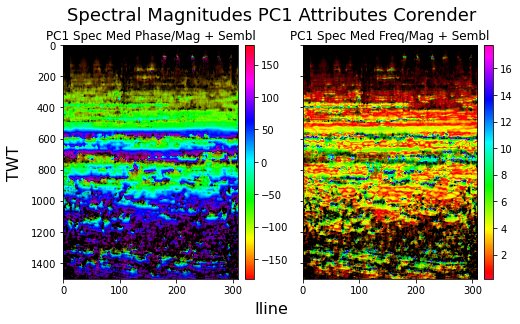

In [98]:
# corender spectral magnitudes PC1 attributes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)
cmap_m = LinearSegmentedColormap.from_list(name='m', colors=[(0,0,0,1), (0,0,0,0)])
cmap_l = LinearSegmentedColormap.from_list(name='l', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,1), 
                                                             (0,0,0,0), (0,0,0,0), (0,0,0,0)])

im1 = ax[0].imshow(PC1_mp_spec_m_trace_attributes_2D[7].T, cmap='hsv', aspect='auto')
ax[0].imshow(PC_mp_spec_m_2D_lst_gray[0].T, cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[0].imshow(sembl_based_coh_2D_gray.T, cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[0].set_title('PC1 Spec Med Phase/Mag + Sembl', size=12)
cax = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, ax=ax)

im2 = ax[1].imshow(PC1_mp_spec_m_trace_attributes_2D[8].T, cmap='gist_rainbow', aspect='auto', 
                   vmin=np.percentile(PC1_mp_spec_m_trace_attributes_2D[8], 1), 
                   vmax=np.percentile(PC1_mp_spec_m_trace_attributes_2D[8], 99))
ax[1].imshow(PC_mp_spec_m_2D_lst_gray[0].T, cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[1].imshow(sembl_based_coh_2D_gray.T, cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[1].set_title('PC1 Spec Med Freq/Mag + Sembl', size=12)
cax = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, ax=ax)
    
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Spectral Magnitudes PC1 Attributes Corender', ha='center', va='center', size=18)
plt.tight_layout()

In [99]:
# convert to grayscale
peak_spec_m_2D_gray = grayscale(peak_spec_m_2D, np.min(peak_spec_m_2D), np.max(peak_spec_m_2D))

# convert to 8-bit unsigned integer
peak_spec_m_2D_gray = np.uint8(peak_spec_m_2D_gray)

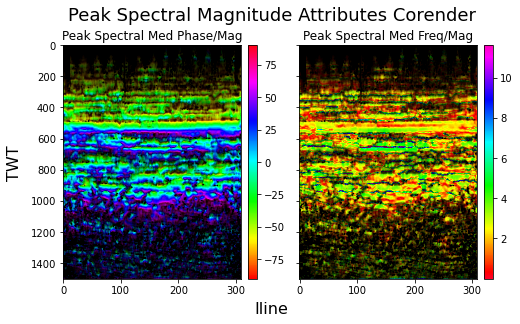

In [100]:
# corender peak spectral magnitude attributes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)
cmap_m = LinearSegmentedColormap.from_list(name='m', colors=[(0,0,0,1), (0,0,0,0)])
cmap_l = LinearSegmentedColormap.from_list(name='l', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,1), 
                                                             (0,0,0,0), (0,0,0,0), (0,0,0,0)])

im1 = ax[0].imshow(peak_spec_m_trace_attributes_2D[7].T, cmap='hsv', aspect='auto')
ax[0].imshow(peak_spec_m_2D_gray.T, cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[0].imshow(sembl_based_coh_2D_gray.T, cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[0].set_title('Peak Spectral Med Phase/Mag', size=12)
cax = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, ax=ax)

im2 = ax[1].imshow(peak_spec_m_trace_attributes_2D[8].T, cmap='gist_rainbow', aspect='auto', 
                   vmin=np.percentile(peak_spec_m_trace_attributes_2D[8], 1), 
                   vmax=np.percentile(peak_spec_m_trace_attributes_2D[8], 99))
ax[1].imshow(peak_spec_m_2D_gray.T, cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[1].imshow(sembl_based_coh_2D_gray.T, cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[1].set_title('Peak Spectral Med Freq/Mag', size=12)
cax = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, ax=ax)
    
fig.text(0.5,-0.01, 'Iline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'TWT', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Peak Spectral Magnitude Attributes Corender', ha='center', va='center', size=18)
plt.tight_layout()

### 3D Short Time Fourier Transform (STFT)

In [101]:
# create working interval (300ms window)
win_signal_3D = signal_3D[:,:,350:-1000]  # twt 700-1000ms

In [102]:
stft_freq_3D, stft_time_3D, stft_signal_3D = stft(win_signal_3D, fs=fs, window='blackman', nperseg=64, noverlap=60, 
                                                  boundary='zeros', padded=True, return_onesided=True)

In [103]:
# STFT average amplitude
stft_amp_3D = np.abs(stft_signal_3D)
stft_amp_3D_avg = np.mean(stft_amp_3D, axis=(0,1))

# seismic average ampitude
win_signal_3D_avg = np.mean(win_signal_3D, axis=(0,1))

In [104]:
stft_amp_3D.shape, stft_amp_3D_avg.shape, win_signal_3D_avg.shape

((309, 230, 33, 39), (33, 39), (151,))

In [105]:
win_time = np.linspace(0.7,1.0,151)
ps_stft_time_3D = np.linspace(0.7,1.0,39)

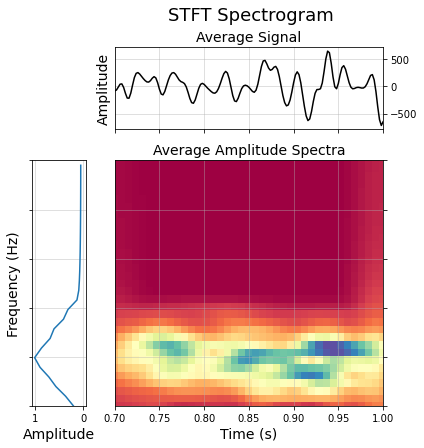

In [106]:
# view average amplitude spectra
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), gridspec_kw={'height_ratios':[1.5,4.5], 'width_ratios':[1,5]})
im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        ax.set_axis_off()
    elif i == 1:
        ax.plot(win_time, win_signal_3D_avg, color='k')
        ax.set_ylabel('Amplitude', size=14)
        ax.yaxis.set_ticks_position('right')
        ax.set_xticklabels([])
        ax.set_xlim([min(win_time), max(win_time)])
        ax.set_title('Average Signal', size=14)
        ax.grid(alpha=0.5)
    elif i == 2:
        ax.plot(rfft_amp_3D_avg_norm, rfft_freq_3D)
        ax.set_xlabel('Amplitude', size=14)
        ax.set_ylabel('Frequency (Hz)', size=14)
        ax.set_yticklabels([])
        ax.set_xlim([-0.05,1.05])
        ax.set_ylim([np.min(stft_freq_3D), np.max(stft_freq_3D)])
        ax.invert_xaxis()
    else:
        im[i] = ax.pcolormesh(ps_stft_time_3D, stft_freq_3D, stft_amp_3D_avg, cmap='Spectral', shading='auto')
        ax.set_xlabel('Time (s)', size=14)
        ax.yaxis.set_ticks_position('right')
        ax.set_yticklabels([])
        ax.set_xlim([min(win_time), max(win_time)])
        ax.set_ylim([np.min(stft_freq_3D), np.max(stft_freq_3D)])
        ax.set_title('Average Amplitude Spectra', size=14)
    ax.grid(alpha=0.5)
fig.text(0.59,1.01, 'STFT Spectrogram', ha='center', va='center', size=18)
plt.tight_layout()

In [107]:
# resize time and frequency axes of 3D volume
spec_mag_3D = stft_amp_3D
spec_mag_3D = zoom(spec_mag_3D, [1, 1, 1, 151/spec_mag_3D.shape[3]])
spec_mag_3D = spec_mag_3D[:,:,:,50:-50]
spec_mag_3D = zoom(spec_mag_3D, [1, 1, 250/spec_mag_3D.shape[2], 1])

In [108]:
spec_mag_3D.shape

(309, 230, 250, 51)

#### Seismic Attributes 3D

In [109]:
# create complex trace attributes function
def traces_3D(real, dt):
    
    # signal components
    R_trace = real
    C_trace = hilbert(R_trace, axis=-1)
    I_trace = np.imag(C_trace)
        
    # instantaneous attributes
    env = np.abs(C_trace)  # envelope
    phase = np.rad2deg(np.angle(C_trace))  # phase
    freq = np.abs((1/(2*np.pi))*(np.gradient(np.unwrap(np.deg2rad(phase)), dt, axis=-1)))  # frequency
    
    # rac = np.gradient(env, dt, axis=-1)/env  # relative amplitude change
    # band = (1/(2*np.pi))*np.abs(rac)  # instantaneous bandwidth
    # dom_freq = np.hypot(freq, band)  # dominant frequency
    # sweet = env/np.sqrt(dom_freq)  # sweetness
    
    def rms(real):
        rms = np.sqrt(np.mean(real**2))
        return rms
    
    rms_env = ndimage.generic_filter(env, rms, size=(3,3,3), mode='reflect')  # root mean square envelope
    med_phase = ndimage.median_filter(phase, size=(3,3,3), mode='reflect')  # median filtered phase
    med_freq = ndimage.median_filter(freq, size=(3,3,3), mode='reflect')  # median filtered frequency
    
    # create a boolean array of trough locations
    troughs_idx = argrelmin(env, axis=-1, order=1, mode='clip')
    troughs = np.zeros(env.shape, dtype=bool)
    troughs[troughs_idx] = True
    troughs = np.cumsum(troughs, axis=-1)
    
    # def response(envelope, real, phase, freq, troughs):
        # # response attributes
        # resp_env = np.zeros(envelope.shape)
        # resp_phase = np.zeros(envelope.shape)
        # resp_freq = np.zeros(envelope.shape)
        # app_pol = np.zeros(envelope.shape)
        
        # for i in np.ndindex(envelope.shape[:-1]):
            # # unique classes (True or False)
            # ints = np.unique(troughs[i, j, :])
            
            # for ii in ints:
                # idx = np.where(troughs[i, j, :] == ii)[-1]
                # peak = idx[envelope[i, j, idx].argmax()]
                
                # resp_env[i, j, idx] = envelope[i, j, peak]  # response envelope
                # resp_phase[i, j, idx] = phase[i, j, peak]  # response phase
                # resp_freq[i, j, idx] = freq[i, j, peak]  # response frequency
                # app_pol[i, j, idx] = envelope[i, j, peak] * np.sign(real[i, j, peak]) # apparent polarity
                
        # return resp_env, resp_phase, resp_freq, app_pol
    
    # resp_env, resp_phase, resp_freq, app_pol = response(env, R_trace, phase, freq, troughs)
    
    return rms_env, med_phase, med_freq

In [110]:
# create edge detection attributes function
def edges_3D(data, zwin, window):
    
    # # crosscorrelation based coherence
    # corr_coh_2D = np.zeros_like(data)
    # nx, ny, nz = data.shape
    # # pad data by reflecting boundary
    # padded = np.pad(data, ((0, 1), (0, 1), (zwin//2, zwin//2)), mode='reflect')
    
    # for x, y, z, in np.ndindex(nx, ny, nz):
        # center_trace = data[x, y, :]  # center trace (full length of time axis)   
        # x_trace = padded[x+1, y, z:z+zwin]  # adjacent traces (moving window along time axis)
        # y_trace = padded[x, y+1, z:z+zwin]  # adjacent traces (moving window along time axis)
        # # cross correlate (output length = center_trace.size - x_trace.size + 1)
        # xcorr = np.correlate(center_trace, x_trace)
        # ycorr = np.correlate(center_trace, y_trace)
        # # maximum normalized cross correlation value
        # center_std = center_trace.std()
        # x_std = x_trace.std()
        # y_std = y_trace.std()
        # px = xcorr.max() / (xcorr.size * center_std * x_std)
        # py = ycorr.max() / (ycorr.size * center_std * y_std)
        # corr_coh_2D[x,y,z] = np.sqrt(px**2 + py**2)  # normalized crosscorrelation based coherence

    # corr_coh_2D = np.clip(corr_coh_2D, a_min=0, a_max=1)
    # corr_coh_2D = np.nan_to_num(corr_coh_2D, nan=0, posinf=1, neginf=0)
    
    # semblance based coherence
    def sembl_func(region):
        # reshape 1D generic filter input to window shape
        region = region.reshape(window)
        # reshape window to 2D array (ntraces by nsamples)
        region = region.reshape(-1, region.shape[-1])
        ntraces, nsamples = region.shape
        
        # in terms of energy ratio
        square_of_sums = np.sum(region, axis=0)**2
        sum_of_squares = np.sum(region**2, axis=0)
        sembl = square_of_sums.sum() / sum_of_squares.sum()
        
        # alternatively in terms of covariance matrix
        # cov = region.dot(region.T)
        # sembl = cov.sum() / cov.diagonal().sum()
        
        return sembl / ntraces
    
    # semblance is sensitive to amplitude and phase changes (better for stratigraphy)
    sembl_coh = ndimage.generic_filter(data, sembl_func, window)  # semblance based coherence
    sembl_coh[np.isnan(sembl_coh)] = 0
        
    # def eigenstruc_func(region):
        # # reshape 1D generic filter input to window shape
        # region = region.reshape(window)
        # # reshape window to 2D array (ntraces by nsamples)
        # region = region.reshape(-1, region.shape[-1])
        
        # # ratio of the largest eigenvalue to sum of eigenvalues
        # cov = region.dot(region.T)
        # vals = np.linalg.eigvalsh(cov)
        # eigenstruc = vals.max() / vals.sum()
        
        # return eigenstruc
    
    # # eigenstructure is sensitive only to phase changes (better for subtle structures)
    # eigenstruc_coh = ndimage.generic_filter(data, eigenstruc_func, window)  # eigenstructure based coherence
    # eigenstruc_coh[np.isnan(eigenstruc_coh)] = 0
    
    # # gradient magnitude
    # gauss_gdmg = ndimage.gaussian_gradient_magnitude(data, sigma=(1,1,1), mode='reflect')  
    # gauss_gdmg = gauss_gdmg/np.max(gauss_gdmg)  # normalized gaussian gradient magnitude
    
    return sembl_coh

In [111]:
# compute complex trace attributes
trace_attributes_3D = traces_3D(sub_signal_3D, dt)

# compute edge detection attributes
edge_attributes_3D = edges_3D(sub_signal_3D, zwin=None, window=(3,3,9))

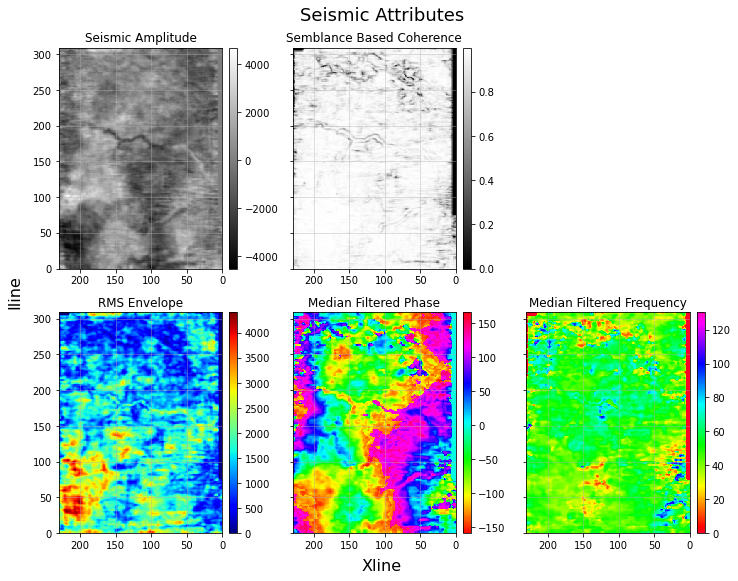

In [112]:
# view seismic attributes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,7.5), sharey=True, constrained_layout=False)
z_sel = 22  # twt 842ms

im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(sub_signal_3D[:,:,z_sel-1], shading='auto', cmap='gray', 
                              vmin=np.percentile(sub_signal_3D[:,:,z_sel-1], 0), 
                              vmax=np.percentile(sub_signal_3D[:,:,z_sel-1], 100))
        ax.set_title('Seismic Amplitude', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i == 1:
        im[i] = ax.pcolormesh(edge_attributes_3D[:,:,z_sel-1], shading='auto', cmap=edge_cmaps[i-1], 
                              vmin=np.percentile(edge_attributes_3D[:,:,z_sel-1], 0), 
                              vmax=np.percentile(edge_attributes_3D[:,:,z_sel-1], 100))
        ax.set_title(edge_titles[i-1], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i == 2:
        ax.set_axis_off()
    else:
        im[i] = ax.pcolormesh(trace_attributes_3D[i-3][:,:,z_sel-1], shading='auto', cmap=trace_cmaps[i+3], 
                              vmin=np.percentile(trace_attributes_3D[i-3][:,:,z_sel-1], 0), 
                              vmax=np.percentile(trace_attributes_3D[i-3][:,:,z_sel-1], 100))
        ax.set_title(trace_titles[i+3], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    ax.grid(alpha=0.5)
    ax.invert_xaxis()
fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Seismic Attributes', ha='center', va='center', size=18)
plt.tight_layout()

#### Peak Spectral Component 3D

In [113]:
peak_spec_m_3D = spec_mag_3D[:,:,peak_spec_comp_3D-1,:]

In [114]:
# compute peak spectral magnitude complex trace attributes
peak_spec_m_trace_attributes_3D = traces_3D(peak_spec_m_3D, dt)

# compute peak spectral magnitude edge detection attributes
peak_spec_m_edge_attributes_3D = edges_3D(peak_spec_m_3D, zwin=None, window=(3,3,9))

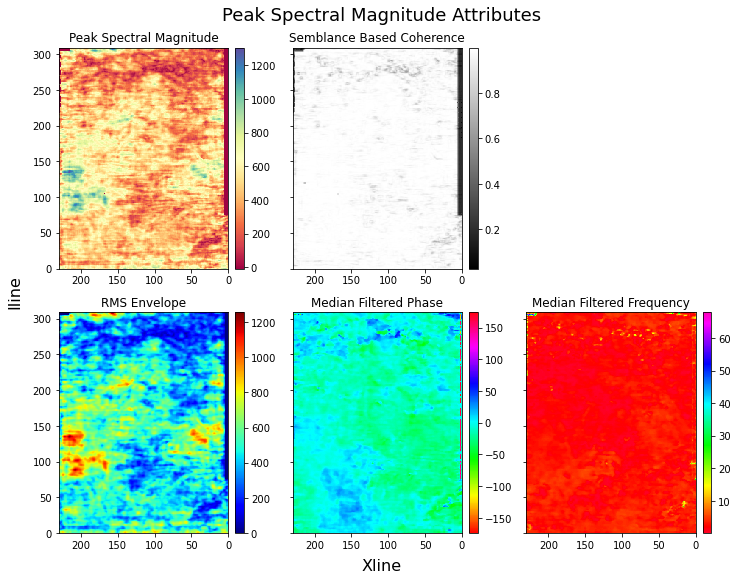

In [115]:
# view peak spectral magnitude attributes
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,7.5), sharey=True, constrained_layout=False)
z_sel = 22  # twt 842ms

im = [i for i in enumerate(fig.axes)]
for i, ax in enumerate(fig.axes):
    if i == 0:
        im[i] = ax.pcolormesh(peak_spec_m_3D[:,:,z_sel-1], shading='auto', cmap='Spectral', 
                              vmin=np.percentile(peak_spec_m_3D[:,:,z_sel-1], 0), 
                              vmax=np.percentile(peak_spec_m_3D[:,:,z_sel-1], 100))
        ax.set_title('Peak Spectral Magnitude', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i == 1:
        im[i] = ax.pcolormesh(peak_spec_m_edge_attributes_3D[:,:,z_sel-1], shading='auto', cmap=edge_cmaps[i-1], 
                              vmin=np.percentile(peak_spec_m_edge_attributes_3D[:,:,z_sel-1], 0), 
                              vmax=np.percentile(peak_spec_m_edge_attributes_3D[:,:,z_sel-1], 100))
        ax.set_title(edge_titles[i-1], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    elif i == 2:
        ax.set_axis_off()
    else:
        im[i] = ax.pcolormesh(peak_spec_m_trace_attributes_3D[i-3][:,:,z_sel-1], shading='auto', cmap=trace_cmaps[i+3], 
                              vmin=np.percentile(peak_spec_m_trace_attributes_3D[i-3][:,:,z_sel-1], 0), 
                              vmax=np.percentile(peak_spec_m_trace_attributes_3D[i-3][:,:,z_sel-1], 100))
        ax.set_title(trace_titles[i+3], size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im[i], cax=cax, ax=ax)
    ax.invert_xaxis()
    ax.invert_yaxis()
fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Peak Spectral Magnitude Attributes', ha='center', va='center', size=18)
plt.tight_layout()

#### Low/High Spectral Component 3D

In [116]:
low_spec_m_3D = spec_mag_3D[:,:,low_spec_comp_3D-1,:]
high_spec_m_3D = spec_mag_3D[:,:,high_spec_comp_3D-1,:]

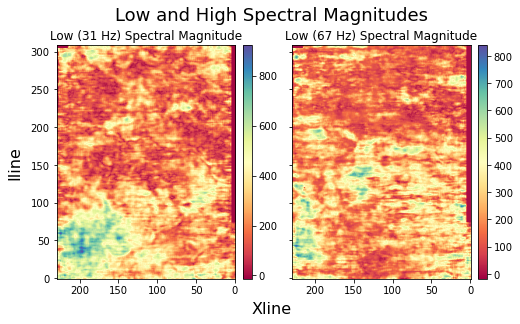

In [117]:
# view low and high spectral magnitudes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)
z_sel = 22  # twt 842ms

im1 = ax[0].imshow(low_spec_m_3D[:,:,z_sel-1], cmap='Spectral', aspect='auto', 
                   vmin=np.percentile(low_spec_m_3D[:,:,z_sel-1], 0), 
                   vmax=np.percentile(low_spec_m_3D[:,:,z_sel-1], 100))
ax[0].set_title('Low (31 Hz) Spectral Magnitude', size=12)
ax[0].invert_xaxis()
ax[0].invert_yaxis()
cax = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, ax=ax)

im2 = ax[1].imshow(high_spec_m_3D[:,:,z_sel-1], cmap='Spectral', aspect='auto', 
                   vmin=np.percentile(high_spec_m_3D[:,:,z_sel-1], 0), 
                   vmax=np.percentile(high_spec_m_3D[:,:,z_sel-1], 100))
ax[1].set_title('Low (67 Hz) Spectral Magnitude', size=12)
ax[1].invert_xaxis()
ax[1].invert_yaxis()
cax = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, ax=ax)

fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Low and High Spectral Magnitudes', ha='center', va='center', size=18)
plt.tight_layout()

#### RGBA Color Blending 3D

In [118]:
# check scale and data type
np.min(peak_spec_m_3D), np.max(peak_spec_m_3D), peak_spec_m_3D.dtype

(-27.059244, 1313.8402, dtype('float32'))

In [119]:
# convert to grayscale
low_spec_m_3D_gray = grayscale(low_spec_m_3D, np.min(low_spec_m_3D), np.max(low_spec_m_3D))
peak_spec_m_3D_gray = grayscale(peak_spec_m_3D, np.min(peak_spec_m_3D), np.max(peak_spec_m_3D))
high_spec_m_3D_gray = grayscale(high_spec_m_3D, np.min(high_spec_m_3D), np.max(high_spec_m_3D))
sembl_based_coh_3D_gray = grayscale(edge_attributes_3D, np.min(edge_attributes_3D), np.max(edge_attributes_3D))

# convert to 8-bit unsigned integer
low_spec_m_3D_gray = np.uint8(low_spec_m_3D_gray)
peak_spec_m_3D_gray = np.uint8(peak_spec_m_3D_gray)
high_spec_m_3D_gray = np.uint8(high_spec_m_3D_gray)
sembl_based_coh_3D_gray = np.uint8(sembl_based_coh_3D_gray)

In [120]:
# check new scale and data type
np.min(peak_spec_m_3D_gray), np.max(peak_spec_m_3D_gray), peak_spec_m_3D_gray.dtype

(0, 255, dtype('uint8'))

In [121]:
# stack spectral components in RGB channels
RGB_m_3D_stack = np.stack([low_spec_m_3D_gray, peak_spec_m_3D_gray, high_spec_m_3D_gray])

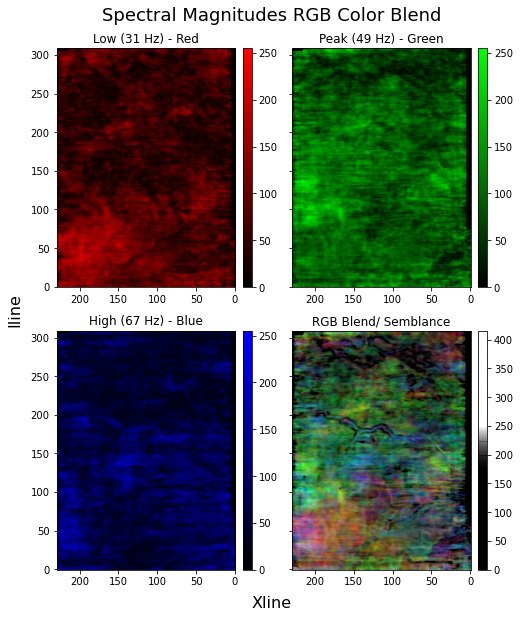

In [122]:
# view RGB principal components blend
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,8), sharey=True)
z_sel = 22  # twt 842ms

cmap_r = LinearSegmentedColormap.from_list(name='r', colors=[(0,0,0,1), (1,0,0,1)])
cmap_g = LinearSegmentedColormap.from_list(name='g', colors=[(0,0,0,1), (0,1,0,1)])
cmap_b = LinearSegmentedColormap.from_list(name='b', colors=[(0,0,0,1), (0,0,1,1)])
cmap_a = LinearSegmentedColormap.from_list(name='a', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,1), 
                                                             (0,0,0,0), (0,0,0,0), (0,0,0,0)])

for i, ax in enumerate(fig.axes):
    if i == 0: 
        im = ax.imshow(low_spec_m_3D_gray[:,:,z_sel-1], cmap=cmap_r, aspect='auto', vmin=0, vmax=255)
        ax.set_title('Low (31 Hz) - Red', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, ax=ax, orientation='vertical')
    elif i == 1: 
        im = ax.imshow(peak_spec_m_3D_gray[:,:,z_sel-1], cmap=cmap_g, aspect='auto', vmin=0, vmax=255)
        ax.set_title('Peak (49 Hz) - Green', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, ax=ax, orientation='vertical')
    elif i == 2: 
        im = ax.imshow(high_spec_m_3D_gray[:,:,z_sel-1], cmap=cmap_b, aspect='auto', vmin=0, vmax=255)
        ax.set_title('High (67 Hz) - Blue', size=12)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, ax=ax, orientation='vertical')
    else:
        im = ax.imshow(RGB_m_3D_stack.transpose(1,2,3,0)[:,:,z_sel-1,:], aspect='auto', vmin=0, vmax=255)
        ax.set_title('RGB Blend/ Semblance', size=12)
        im2 = ax.imshow(sembl_based_coh_3D_gray[:,:,z_sel-1], cmap=cmap_a, aspect='auto', vmin=0, vmax=415)
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im2, cax=cax, ax=ax, orientation='vertical')
    ax.invert_xaxis()
    ax.invert_yaxis()
fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Spectral Magnitudes RGB Color Blend', ha='center', va='center', size=18)
plt.tight_layout()

#### HSL Corendering 3D

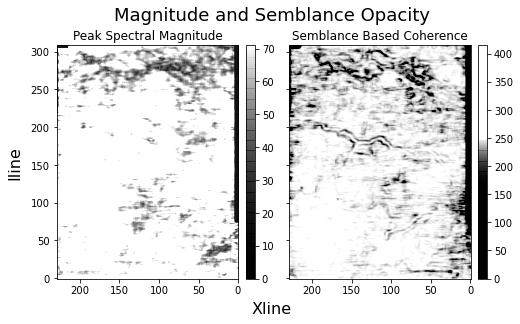

In [123]:
# set opacity range for magnitude and semblance
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)
cmap_m = LinearSegmentedColormap.from_list(name='m', colors=[(0,0,0,1), (0,0,0,0)])
cmap_l = LinearSegmentedColormap.from_list(name='l', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,1), 
                                                             (0,0,0,0), (0,0,0,0), (0,0,0,0)])

im1 = ax[0].imshow(peak_spec_m_3D_gray[:,:,z_sel-1], cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[0].set_title('Peak Spectral Magnitude', size=12)
ax[0].invert_xaxis()
ax[0].invert_yaxis()
cax = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, ax=ax)

im2 = ax[1].imshow(sembl_based_coh_3D_gray[:,:,z_sel-1], cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[1].set_title('Semblance Based Coherence', size=12)
ax[1].invert_xaxis()
ax[1].invert_yaxis()
cax = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, ax=ax)

fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Magnitude and Semblance Opacity', ha='center', va='center', size=18)
plt.tight_layout()

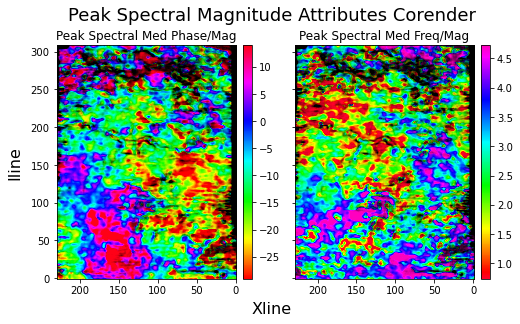

In [124]:
# corender peak spectral magnitude attributes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), sharey=True)
cmap_m = LinearSegmentedColormap.from_list(name='m', colors=[(0,0,0,1), (0,0,0,0)])
cmap_l = LinearSegmentedColormap.from_list(name='l', colors=[(0,0,0,1), (0,0,0,1), (0,0,0,1), 
                                                             (0,0,0,0), (0,0,0,0), (0,0,0,0)])

im1 = ax[0].imshow(peak_spec_m_trace_attributes_3D[-2][:,:,z_sel-1], cmap='hsv', aspect='auto', 
                   vmin=np.percentile(peak_spec_m_trace_attributes_3D[-2][:,:,z_sel-1], 5), 
                   vmax=np.percentile(peak_spec_m_trace_attributes_3D[-2][:,:,z_sel-1], 95))
ax[0].imshow(peak_spec_m_3D_gray[:,:,z_sel-1], cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[0].imshow(sembl_based_coh_3D_gray[:,:,z_sel-1], cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[0].set_title('Peak Spectral Med Phase/Mag', size=12)
ax[0].invert_xaxis()
ax[0].invert_yaxis()
cax = make_axes_locatable(ax[0]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, ax=ax)

im2 = ax[1].imshow(peak_spec_m_trace_attributes_3D[-1][:,:,z_sel-1], cmap='gist_rainbow', aspect='auto', 
                   vmin=np.percentile(peak_spec_m_trace_attributes_3D[-1][:,:,z_sel-1], 5), 
                   vmax=np.percentile(peak_spec_m_trace_attributes_3D[-1][:,:,z_sel-1], 95))
ax[1].imshow(peak_spec_m_3D_gray[:,:,z_sel-1], cmap=cmap_m, aspect='auto', vmin=0, vmax=71)
ax[1].imshow(sembl_based_coh_3D_gray[:,:,z_sel-1], cmap=cmap_l, aspect='auto', vmin=0, vmax=415)
ax[1].set_title('Peak Spectral Med Freq/Mag', size=12)
ax[1].invert_xaxis()
ax[1].invert_yaxis()
cax = make_axes_locatable(ax[1]).append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, ax=ax)
    
fig.text(0.5,-0.01, 'Xline', ha='center', va='center', size=16)
fig.text(-0.01,0.5, 'Iline', ha='center', va='center', rotation='vertical', size=16)
fig.text(0.5,1.01, 'Peak Spectral Magnitude Attributes Corender', ha='center', va='center', size=18)
plt.tight_layout()

### References:
1). Chopra, S., and Marfurt, K. J., 2016, Spectral decomposition and spectral balancing of seismic data: The Leading Edge, 35, 176–179 - http://dx.doi.org/10.1190/tle35020176.1

2). Taner, M. T., Koehler, F., and Sheriff R. E., 1979, Complex seismic trace analysis: Geophysics, 44, 1041-1063 - http://dx.doi.org/10.1190/1.1440994

3). Barnes, A. E., 2007, A tutorial on complex seismic trace analysis: Geophysics, 72, W33–W43 - http://dx.doi.org/10.1190/1.2785048

4). Braden, F., 2018, Complex trace attributes for seismic data: Github, dfitzgerald3/CompleTrace.py - https://github.com/dudley-fitzgerald/d2geo/blob/master/attributes/CompleTrace.py

5). Kington, J., 2015, Semblance, coherence, and other discontinuity attributes: Github, seg/Discontinuity_tutorial.ipynb - https://github.com/seg/tutorials-2015/blob/master/1512_Semblance_coherence_and_discontinuity/Discontinuity_tutorial.ipynb

6). Liu, J., and Marfurt, K. J., 2007, Instantaneous spectral attributes to detect channels: Geophysics, 72, P23–P31 - http://dx.doi.org/10.1190/1.2428268

7). Marfurt, K. J., et al., 1998, 3-D seismic attributes using a semblance-based coherency algorithm: Geophysics, 63, 1150-1165 - http://dx.doi.org/10.1190/1.1444415

8). Scipy Library - https://docs.scipy.org/doc/scipy/reference/index.html

9). Scikit Library - https://scikit-learn.org/stable/index.html

10). Scikit-image Library - https://scikit-image.org/